# Analysis of Medical Cost Personal Dataset

## Introduction

This Medical Cost Personal Dataset contains information on 1338 individuals and 7 characteristics about them. One of characteristics is the dependent variable, charges, which are the individual medical costs billed by health insurance. The other six characteristics are the independent variables (age, sex, bmi, children, smoker, and region). Age is how old the individual is, sex is whether the individual is male or female, bmi is the body mass index of the individual, children is the number of dependents covered by health insurance, smoker is whether the individual smokes or not, and region is the individual's residential area in the US.

In this project I intend to analyse the relationship between the dependent variable, charges, and the six independent variables. By analyzing the relationships, I aim to determine which individual characteristics are most significant when predicting medical costs.

In [119]:
library(readr)
library(ISLR)
library(plyr)
library(tree)
library(glmnet)
library(dplyr)
library(ggplot2)
library(class)
library(caret)
library(e1071)
library(dvmisc)
library(ROCR)
library(boot)
library(gbm)
library(xgboost)
library(randomForest)
library(keras)
insurance <- read_csv("insurance.csv")

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_character(),
  bmi = col_double(),
  children = col_double(),
  smoker = col_character(),
  region = col_character(),
  charges = col_double()
)


In [120]:
# Converting the character variables into factor variables 
# because they are qualitative and checking variables again
insurance$sex <- as.factor(insurance$sex)
insurance$smoker <- as.factor(insurance$smoker)
insurance$region <- as.factor(insurance$region)
insurance$charges <- as.numeric(insurance$charges)
str(insurance)

Classes ‘spec_tbl_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	1338 obs. of  7 variables:
 $ age     : num  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : Factor w/ 2 levels "female","male": 1 2 2 2 2 1 1 1 2 1 ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: num  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : Factor w/ 2 levels "no","yes": 2 1 1 1 1 1 1 1 1 1 ...
 $ region  : Factor w/ 4 levels "northeast","northwest",..: 4 3 3 2 2 3 3 2 1 2 ...
 $ charges : num  16885 1726 4449 21984 3867 ...
 - attr(*, "spec")=
  .. cols(
  ..   age = col_double(),
  ..   sex = col_character(),
  ..   bmi = col_double(),
  ..   children = col_double(),
  ..   smoker = col_character(),
  ..   region = col_character(),
  ..   charges = col_double()
  .. )


## Summary Statistics

In [55]:
# summary statistics of all the independent and dependent variables
summary(insurance)

      age            sex           bmi           children     smoker    
 Min.   :18.00   female:662   Min.   :15.96   Min.   :0.000   no :1064  
 1st Qu.:27.00   male  :676   1st Qu.:26.30   1st Qu.:0.000   yes: 274  
 Median :39.00                Median :30.40   Median :1.000             
 Mean   :39.21                Mean   :30.66   Mean   :1.095             
 3rd Qu.:51.00                3rd Qu.:34.69   3rd Qu.:2.000             
 Max.   :64.00                Max.   :53.13   Max.   :5.000             
       region       charges     
 northeast:324   Min.   : 1122  
 northwest:325   1st Qu.: 4740  
 southeast:364   Median : 9382  
 southwest:325   Mean   :13270  
                 3rd Qu.:16640  
                 Max.   :63770  

This shows the summary statistics of all the independent and dependent variables. From this you can interpret that average age of the data is 39.21, there are about the same amount of males and females, the average bmi is 30.66, there are significantly more nonsmokers than smokers, and that the average charge is 13270.

In [4]:
# summary statistics of smokers
summary(subset(insurance, smoker == "yes"))

      age            sex           bmi           children     smoker   
 Min.   :18.00   female:115   Min.   :17.20   Min.   :0.000   no :  0  
 1st Qu.:27.00   male  :159   1st Qu.:26.08   1st Qu.:0.000   yes:274  
 Median :38.00                Median :30.45   Median :1.000            
 Mean   :38.51                Mean   :30.71   Mean   :1.113            
 3rd Qu.:49.00                3rd Qu.:35.20   3rd Qu.:2.000            
 Max.   :64.00                Max.   :52.58   Max.   :5.000            
       region      charges     
 northeast:67   Min.   :12829  
 northwest:58   1st Qu.:20826  
 southeast:91   Median :34456  
 southwest:58   Mean   :32050  
                3rd Qu.:41019  
                Max.   :63770  

This shows the summary statistics of all the independent and dependent variables of smokers. From this you can interpret that average age of the data is 38.51, there are about the same amount of males and females, the average bmi is 30.71, and that the average charge is 32050.

In [5]:
# summary statistics of non-smokers
summary(subset(insurance, smoker == "no"))

      age            sex           bmi           children    smoker    
 Min.   :18.00   female:547   Min.   :15.96   Min.   :0.00   no :1064  
 1st Qu.:26.75   male  :517   1st Qu.:26.32   1st Qu.:0.00   yes:   0  
 Median :40.00                Median :30.35   Median :1.00             
 Mean   :39.39                Mean   :30.65   Mean   :1.09             
 3rd Qu.:52.00                3rd Qu.:34.43   3rd Qu.:2.00             
 Max.   :64.00                Max.   :53.13   Max.   :5.00             
       region       charges     
 northeast:257   Min.   : 1122  
 northwest:267   1st Qu.: 3986  
 southeast:273   Median : 7345  
 southwest:267   Mean   : 8434  
                 3rd Qu.:11363  
                 Max.   :36911  

This shows the summary statistics of all the independent and dependent variables of smokers. From this you can interpret that average age of the data is 39.39, there are about the same amount of males and females, the average bmi is 30.65, and that the average charge is 8434.

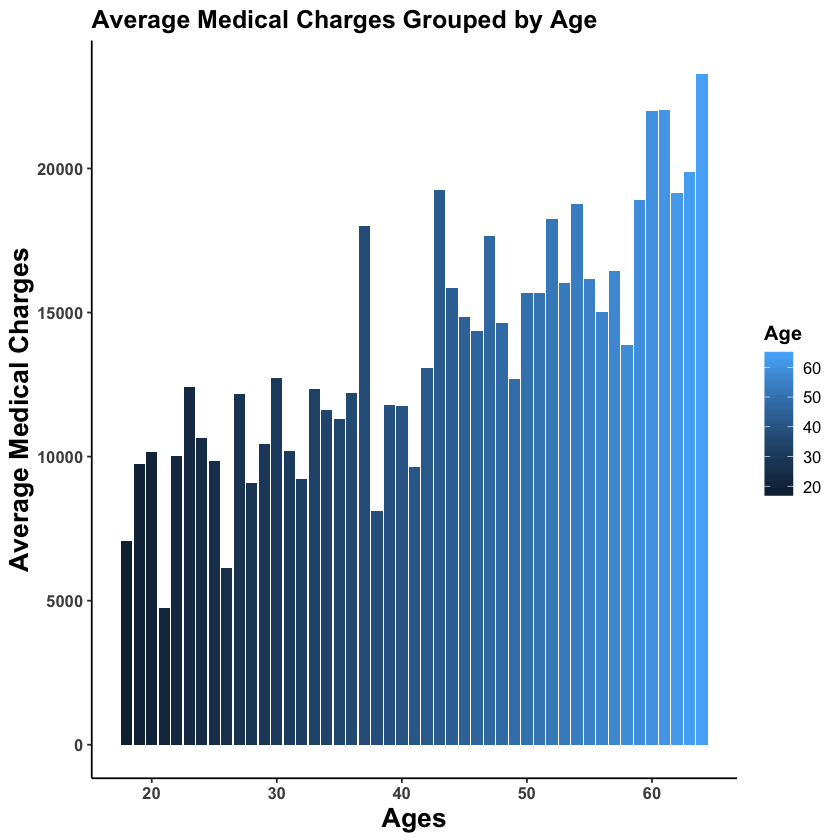

In [6]:
insurance %>% group_by(Age = insurance$age) %>% summarise(AveCharges = mean(charges)) %>% 
ggplot(aes(x = Age, y = AveCharges, fill = Age))+ 
    geom_bar(stat = "identity") + 
    theme_classic() + 
    theme(axis.title = element_text(size = 16, face = "bold"),
   axis.text = element_text(size = 10, face = "bold"),
   strip.text = element_text(size = 13, face = "bold"),
   legend.title = element_text(size = 12, face = "bold"),
   legend.text = element_text(size = 10),
   plot.title = element_text(size = 15, face = "bold"))+
    labs(
        x = "Ages",
        y = "Average Medical Charges",
        title = "Average Medical Charges Grouped by Age" 
    )

This bar graph shows the insurance data grouped by age and for each age, it shows it's average medical cost. Overall, the graph shows a trend that as age increases, average medical charges also increases.

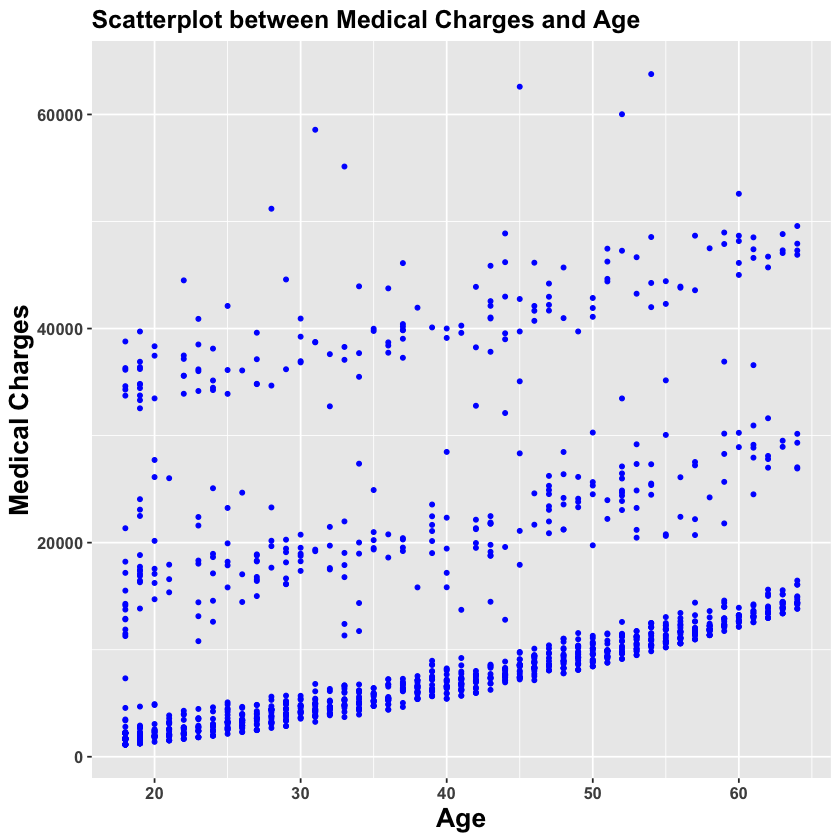

In [7]:
# Graph of age on medical costs
ggplot(insurance, aes(x=age, y=charges))+ 
  geom_point(color='blue', size = 1) + 
  theme(axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 10, face = "bold"),
    strip.text = element_text(size = 13, face = "bold"),
    plot.title = element_text(size = 15, face = "bold")) +
  labs(y="Medical Charges", x="Age", title = "Scatterplot between Medical Charges and Age")

This scatterplot shows the distribution of medical charges on age for all observations. Like the last graph it shows a trend that as age increases, so does medical charges.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


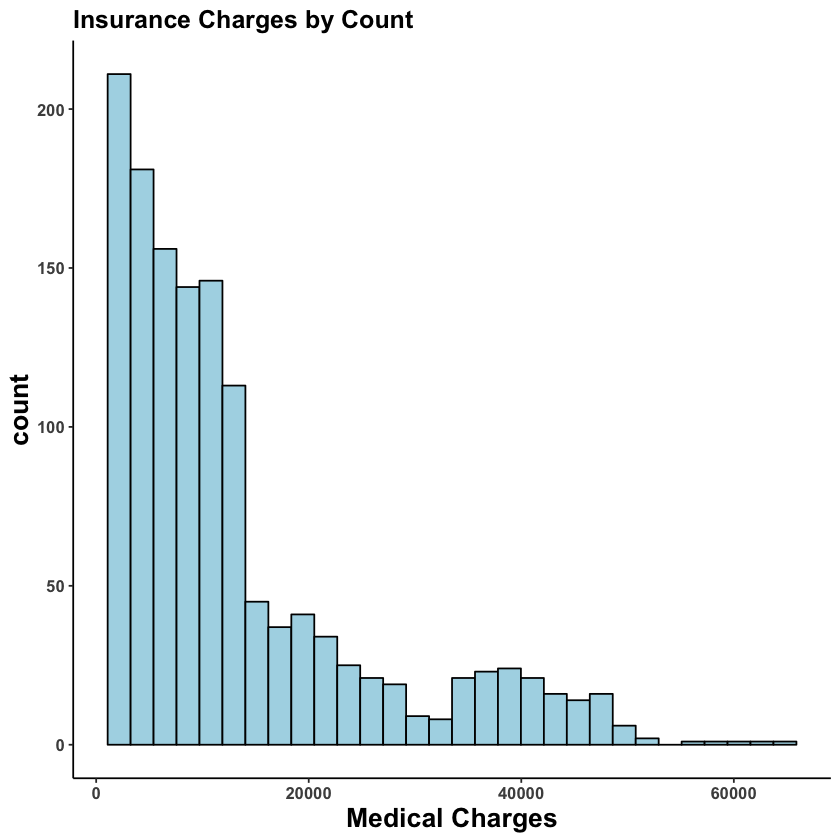

In [8]:
ggplot(insurance, aes(charges))+ 
    geom_histogram(color = "black", fill = "lightblue")+
    theme_classic()+
    theme(axis.title = element_text(size = 16, face = "bold"),
   axis.text = element_text(size = 10, face = "bold"),
   strip.text = element_text(size = 13, face = "bold"),
   legend.title = element_text(size = 12, face = "bold"),
   legend.text = element_text(size = 10),
   plot.title = element_text(size = 15, face = "bold"))+ 
    labs(
        x = "Medical Charges",
        title = "Insurance Charges by Count" 
    )

This histogram shows the distribution of medical charges and the number of observations. In general, the graphs shows that as medical charges increase, the less observations there are.



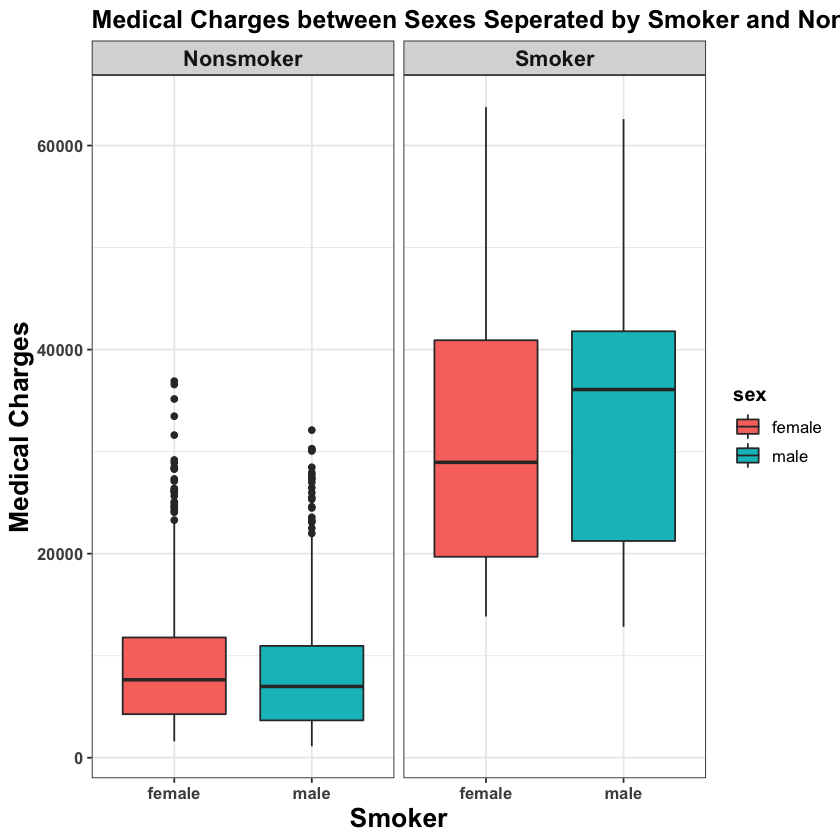

In [9]:
ggplot(insurance) +
 theme_bw() +
 theme(axis.title = element_text(size = 16, face = "bold"),
   axis.text = element_text(size = 10, face = "bold"),
   strip.text = element_text(size = 13, face = "bold"),
   legend.title = element_text(size = 12, face = "bold"),
   legend.text = element_text(size = 10),
   plot.title = element_text(size = 15, face = "bold"))+
 geom_boxplot(aes(x = sex, y = charges, fill = sex)) +
 facet_grid(. ~ smoker, labeller = labeller(smoker = c(no = "Nonsmoker", 
   yes = "Smoker"))) + 
   labs(x = "Smoker", y = "Medical Charges", title = "Medical Charges between Sexes Seperated by Smoker and Nonsmokers")


These boxplot depicts the medical charges between sexes seperated by smoker and nonsmokers. The graphs shows that smokers whether it be male or female have significantly higher average medical charges than nonsmokers.

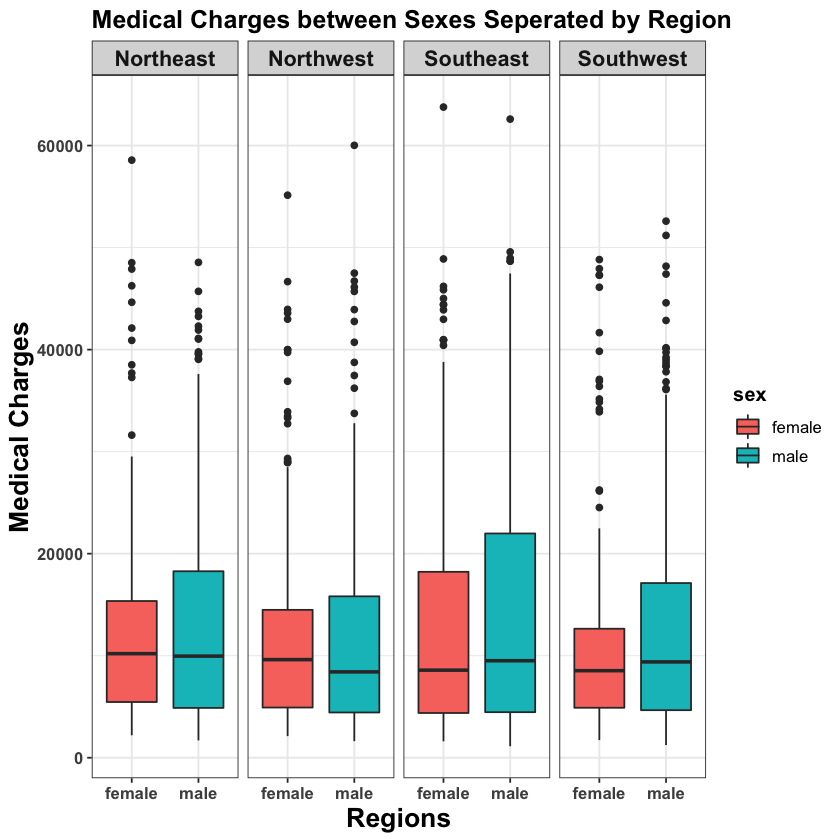

In [10]:
# Split boxplots showing the relationship of region and sex on medical charges
ggplot(insurance) +
 theme_bw() +
 theme(axis.title = element_text(size = 16, face = "bold"),
   axis.text = element_text(size = 10, face = "bold"),
   strip.text = element_text(size = 13, face = "bold"),
   legend.title = element_text(size = 12, face = "bold"),
   legend.text = element_text(size = 10),
   plot.title = element_text(size = 15, face = "bold"))+
 geom_boxplot(aes(x = sex, y = charges, fill = sex)) +
 facet_grid(. ~ region, labeller = labeller(region = c(northeast = "Northeast", 
   northwest = "Northwest", southeast = "Southeast", southwest = "Southwest"))) + 
   labs(x = "Regions", y = "Medical Charges", title = "Medical Charges between Sexes Seperated by Region")

These boxplot depicts the medical charges between sexes seperated by regions. The graphs shows that every region has roughly the same medical charges distribution for males and females.



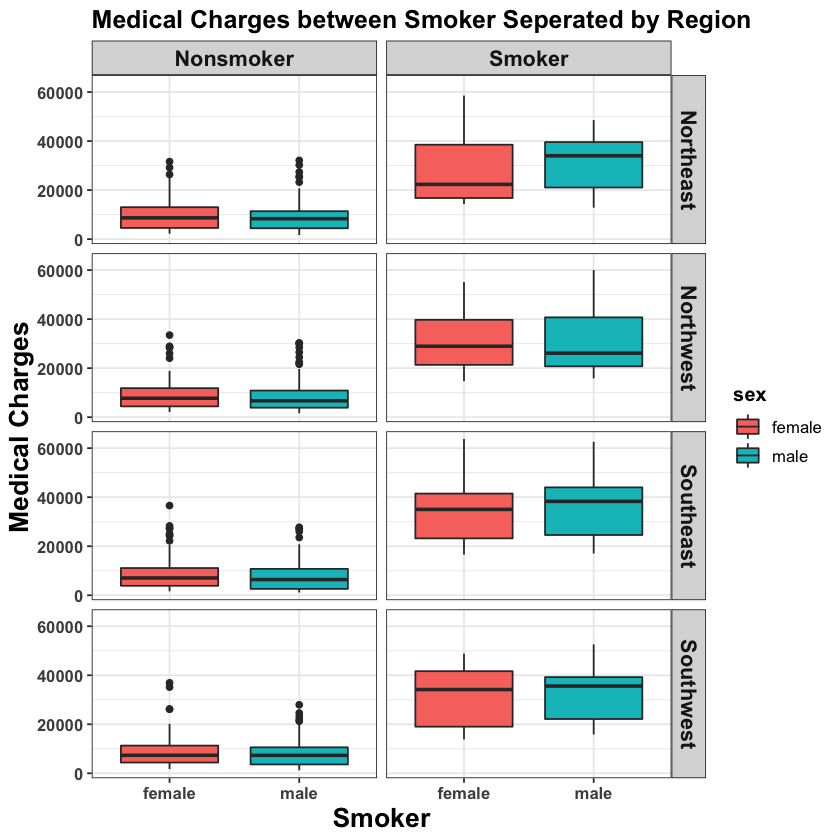

In [11]:
# Split boxplots showing the relationship of smoker, region, and sex on medical charges
ggplot(insurance) +
theme_bw() +
theme(axis.title = element_text(size = 16, face = "bold"),
     axis.text = element_text(size = 10, face = "bold"),
     strip.text = element_text(size = 13, face = "bold"),
     legend.title = element_text(size = 12, face = "bold"),
     legend.text = element_text(size = 10),
     plot.title = element_text(size = 15, face = "bold")) +
geom_boxplot(aes(x = sex, y = charges, fill = sex)) +
facet_grid(region ~ smoker,
          labeller = labeller(smoker = c(no = "Nonsmoker",
                                         yes = "Smoker"),
                              region = c(northeast = "Northeast",
                                         northwest = "Northwest",
                                         southeast = "Southeast",
                                         southwest = "Southwest"))) +
labs(x = "Smoker", y = "Medical Charges", title = "Medical Charges between Smoker Seperated by Region")

These boxplot depicts the medical charges between sex seperated by region and by smoker and nonsmokers. The graphs shows that smokers whether it be male or female have significantly higher average medical charges than nonsmokers in every region.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


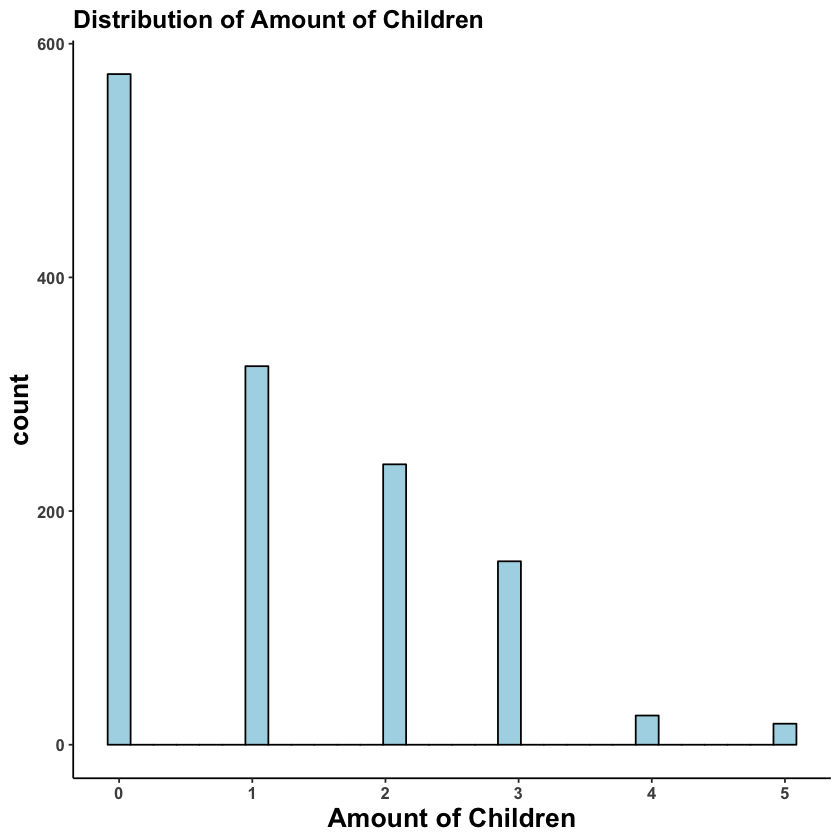

In [12]:
ggplot(insurance, aes(children))+ 
    geom_histogram(color = "black", fill = "lightblue")+
    theme_classic()+
    theme(axis.title = element_text(size = 16, face = "bold"),
   axis.text = element_text(size = 10, face = "bold"),
   strip.text = element_text(size = 13, face = "bold"),
   legend.title = element_text(size = 12, face = "bold"),
   legend.text = element_text(size = 10),
   plot.title = element_text(size = 15, face = "bold"))+ 
    labs(
        x = "Amount of Children",
        title = "Distribution of Amount of Children" 
    )

This histogram seperates the data by amount of children and the number of observations. As expected, the graphs shows that as the amount of children increases, the less observations there are. This is expected because you would likely see more parents with a less number of children and more number of children such as 4 or 5 children.

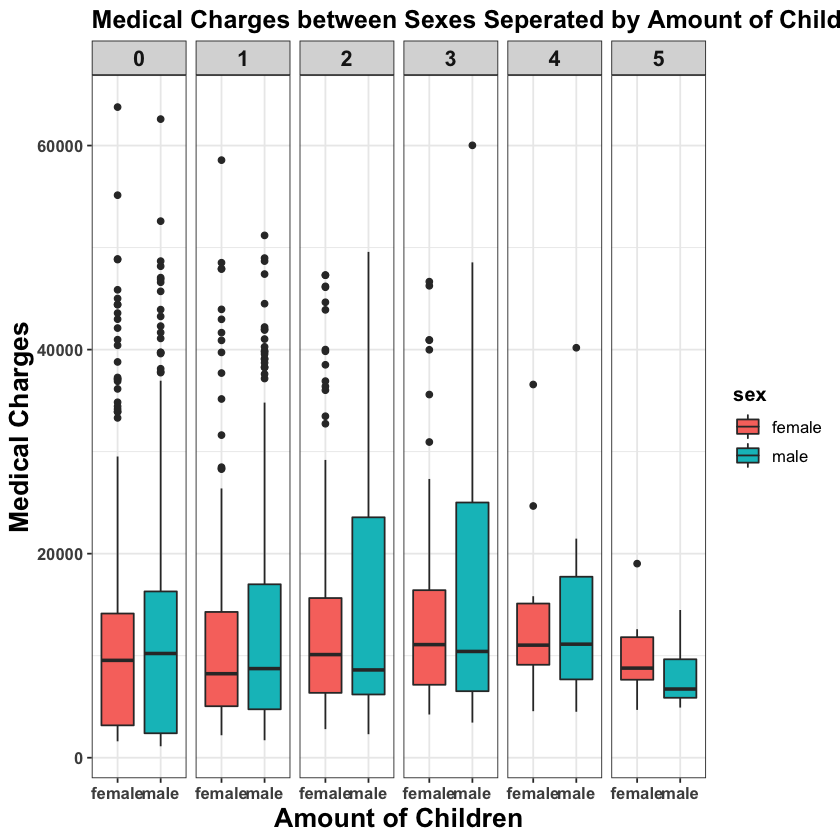

In [13]:
# Split boxplot graphs showing the relationship of amount of children and sex on medical charges
ggplot(insurance) +
  theme_bw() +
  theme(axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 10, face = "bold"),
    strip.text = element_text(size = 13, face = "bold"),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10),
    plot.title = element_text(size = 15, face = "bold")) +
  geom_boxplot(aes(x = sex, y = charges, fill = sex)) +
  facet_grid(. ~ children) + 
    labs(x = "Amount of Children", y = "Medical Charges", 
         title = "Medical Charges between Sexes Seperated by Amount of Children")

These boxplot depicts the medical charges between sex seperated by the amount of children. The graphs shows that as the amount of children goes up, the interquartile range widens and the maximum also increases. I believe that this trend would also show for four and five children, however there are not enough observations of these groups as shown in the previous graph.

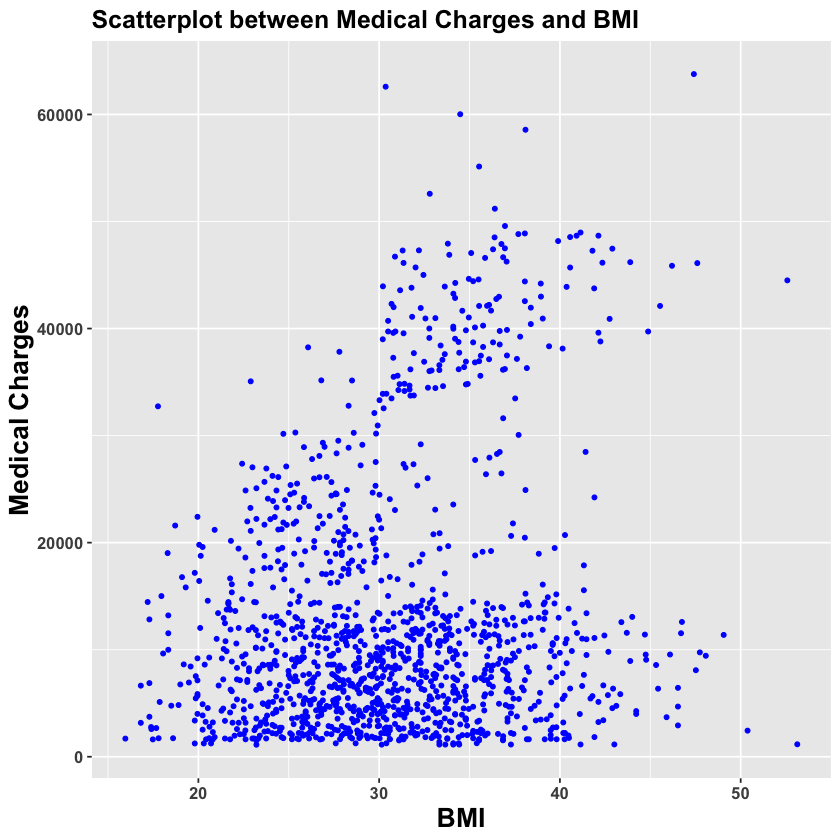

In [14]:
# Graph of bmi on medical costs
ggplot(insurance, aes(x=bmi, y=charges))+
  geom_point(color='blue', size = 1) +
    theme(axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 10, face = "bold"),
    strip.text = element_text(size = 13, face = "bold"),
    plot.title = element_text(size = 15, face = "bold")) +
  labs(y="Medical Charges", x="BMI", title = "Scatterplot between Medical Charges and BMI")

This graph shoes the distribution of medical charges on BMI. The graph shoes that as BMI increases, there is an higher distribution of medical charges that also shows increase medical charges.

# Linear Regression

In [15]:
insurance = insurance
names(insurance)

[1] "age"      "sex"      "bmi"      "children" "smoker"   "region"   "charges"

In [16]:
lm.fit=lm(charges~.,data=insurance)
summary(lm.fit)


Call:
lm(formula = charges ~ ., data = insurance)

Residuals:
     Min       1Q   Median       3Q      Max 
-11304.9  -2848.1   -982.1   1393.9  29992.8 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11938.5      987.8 -12.086  < 2e-16 ***
age                256.9       11.9  21.587  < 2e-16 ***
sexmale           -131.3      332.9  -0.394 0.693348    
bmi                339.2       28.6  11.860  < 2e-16 ***
children           475.5      137.8   3.451 0.000577 ***
smokeryes        23848.5      413.1  57.723  < 2e-16 ***
regionnorthwest   -353.0      476.3  -0.741 0.458769    
regionsoutheast  -1035.0      478.7  -2.162 0.030782 *  
regionsouthwest   -960.0      477.9  -2.009 0.044765 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6062 on 1329 degrees of freedom
Multiple R-squared:  0.7509,	Adjusted R-squared:  0.7494 
F-statistic: 500.8 on 8 and 1329 DF,  p-value: < 2.2e-16


I ran the model on all of the covariates to observe which variables are significant and not significant. And it seems sex and regionnorthwest are not significant.

In [17]:
lm.fit=lm(charges~.-region-sex,data=insurance)
summary(lm.fit)


Call:
lm(formula = charges ~ . - region - sex, data = insurance)

Residuals:
     Min       1Q   Median       3Q      Max 
-11897.9  -2920.8   -986.6   1392.2  29509.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -12102.77     941.98 -12.848  < 2e-16 ***
age            257.85      11.90  21.675  < 2e-16 ***
bmi            321.85      27.38  11.756  < 2e-16 ***
children       473.50     137.79   3.436 0.000608 ***
smokeryes    23811.40     411.22  57.904  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6068 on 1333 degrees of freedom
Multiple R-squared:  0.7497,	Adjusted R-squared:  0.7489 
F-statistic: 998.1 on 4 and 1333 DF,  p-value: < 2.2e-16


I removes region and sex because they were not significant. The model looks good but I believe that there is a better model.

In [18]:
lm.fit=lm(charges~.-region,data=insurance)
summary(lm.fit)


Call:
lm(formula = charges ~ . - region, data = insurance)

Residuals:
     Min       1Q   Median       3Q      Max 
-11837.2  -2916.7   -994.2   1375.3  29565.5 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -12052.46     951.26 -12.670  < 2e-16 ***
age            257.73      11.90  21.651  < 2e-16 ***
sexmale       -128.64     333.36  -0.386 0.699641    
bmi            322.36      27.42  11.757  < 2e-16 ***
children       474.41     137.86   3.441 0.000597 ***
smokeryes    23823.39     412.52  57.750  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6070 on 1332 degrees of freedom
Multiple R-squared:  0.7497,	Adjusted R-squared:  0.7488 
F-statistic:   798 on 5 and 1332 DF,  p-value: < 2.2e-16


I removed just the region variable because it was not significant. I wanted to see the difference of removing region seperately.

In [19]:
lm.fit=lm(charges~.-sex,data=insurance)
summary(lm.fit)


Call:
lm(formula = charges ~ . - sex, data = insurance)

Residuals:
     Min       1Q   Median       3Q      Max 
-11367.2  -2835.4   -979.7   1361.9  29935.5 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11990.27     978.76 -12.250  < 2e-16 ***
age                256.97      11.89  21.610  < 2e-16 ***
bmi                338.66      28.56  11.858  < 2e-16 ***
children           474.57     137.74   3.445 0.000588 ***
smokeryes        23836.30     411.86  57.875  < 2e-16 ***
regionnorthwest   -352.18     476.12  -0.740 0.459618    
regionsoutheast  -1034.36     478.54  -2.162 0.030834 *  
regionsouthwest   -959.37     477.78  -2.008 0.044846 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6060 on 1330 degrees of freedom
Multiple R-squared:  0.7509,	Adjusted R-squared:  0.7496 
F-statistic: 572.7 on 7 and 1330 DF,  p-value: < 2.2e-16


Comparing the four linear regressions, I believe that the linear models that includes all variables except for sex is the best choice because it gets rid of an insignificant variables as well as have the highest adjusted R-squared and a high F-statistic.. However I should also verify if my choice is correct by using the step function.

In [20]:
lm.fit = step(lm.fit)
summary(lm.fit)

Start:  AIC=23314.58
charges ~ (age + sex + bmi + children + smoker + region) - sex

           Df  Sum of Sq        RSS   AIC
<none>                   4.8845e+10 23315
- region    3 2.3320e+08 4.9078e+10 23315
- children  1 4.3596e+08 4.9281e+10 23324
- bmi       1 5.1645e+09 5.4010e+10 23447
- age       1 1.7151e+10 6.5996e+10 23715
- smoker    1 1.2301e+11 1.7186e+11 24996



Call:
lm(formula = charges ~ (age + sex + bmi + children + smoker + 
    region) - sex, data = insurance)

Residuals:
     Min       1Q   Median       3Q      Max 
-11367.2  -2835.4   -979.7   1361.9  29935.5 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11990.27     978.76 -12.250  < 2e-16 ***
age                256.97      11.89  21.610  < 2e-16 ***
bmi                338.66      28.56  11.858  < 2e-16 ***
children           474.57     137.74   3.445 0.000588 ***
smokeryes        23836.30     411.86  57.875  < 2e-16 ***
regionnorthwest   -352.18     476.12  -0.740 0.459618    
regionsoutheast  -1034.36     478.54  -2.162 0.030834 *  
regionsouthwest   -959.37     477.78  -2.008 0.044846 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6060 on 1330 degrees of freedom
Multiple R-squared:  0.7509,	Adjusted R-squared:  0.7496 
F-statistic: 572.7 on 7 and 1330 DF,  p-value: < 2.2e-16


The step function outputted the same model as the one I chose, so I am more confident that this is the best linear model.

In this model, the Y varialbe is medical charages and the X variables I chose were age, bmi, children, smoker, and region. The relationships between the independent variables on the dependent varaible makes sense because in the past graphs I have already shown that age, bmi, children, and smoker have a strong effect on medical charges while region showed a moderate effect on medical charges.

The coefficients of each X on Y are interpreted by:

- age: As age increases by 1 year, medical charges increases on average by 256.97 dollars
- bmi: As bmi increases by 1 unit, medical charges increases on average by 338.66 dollars
- children: As the number of children increases, medical charges increases on average by 474.57 dollars
- Smokeryes: If the individual is a smoker, medical charges increases on average by 23,836.30 dollars
- regionnorthwest: If the individual is from the northwest region of the US, medical charges decreases on average by 352.18 dollars
- regionsoutheast: If the individual is from the southeast region of the US, medical charges decreases on average by 1034.36 dollars
- regionsouthwest: If the individual is from the southwest region of the US, medical charges decreases on average by 959.37 dollars

All the coefficients excluding regionnorthwest are all significantly different from zero. The F statistic is 525.7 which provides clear evidence that the model is a good fit for the data. We can learned from the F statistic that this model is a better fit if we only had an intercept only model.

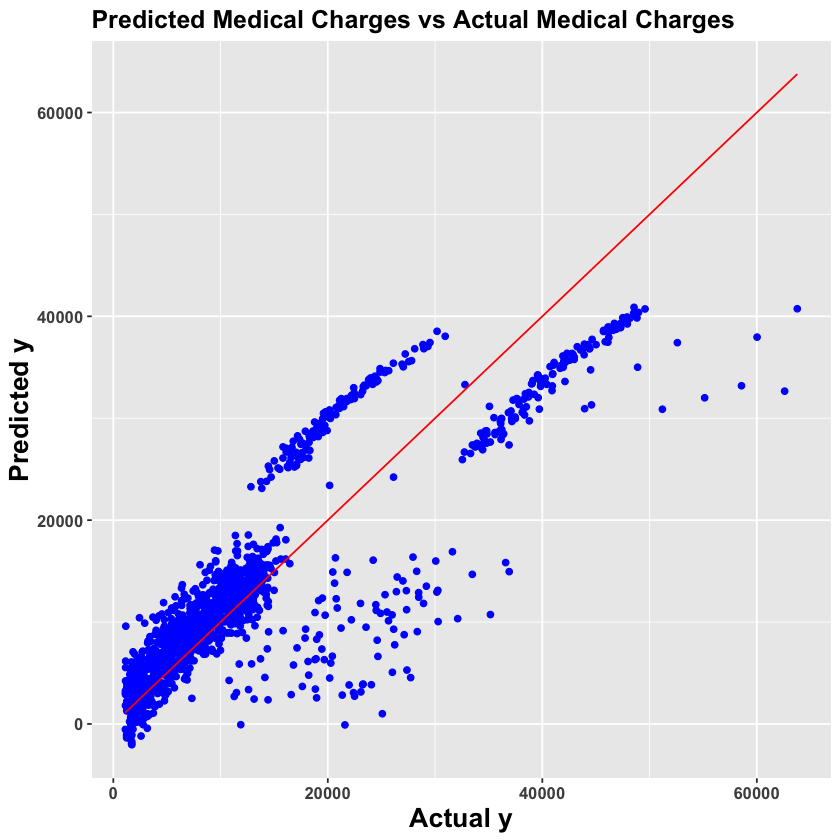

In [21]:
ggplot() +
  geom_point(aes(x=insurance$charges, y = predict(lm.fit)),
             colour = 'blue') +
  geom_line(aes(x = insurance$charges, y = insurance$charges ),
            colour = 'red') +
    theme(axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 10, face = "bold"),
    strip.text = element_text(size = 13, face = "bold"),
    plot.title = element_text(size = 15, face = "bold")) +
  ggtitle("Predicted Medical Charges vs Actual Medical Charges") +
  xlab("Actual y") + ylab("Predicted y")

The Y hat vs Y plot that from roughly 18000 to 32000 on the x axis, the prediction is underestimating the actual values. While from roughly 33000, the prediction is overestimating the actual values.

To identify the which variables are contributing to this undering and overestimating of the actual values, I compared all the residuals against each individual X variable, I was able to conclude that the reason the Predicted vs Actual graph is over and underestimating the values is largely due to BMI as well as smoker. This is because in the BMI graph, it shows two different clusters around the main cluster. And in the smoker graph, it seems like the position of the datapoints are uneven around the red line.

In [22]:
lm.summary = summary(lm.fit)
lm.summary$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-11990.2699,978.76153,-12.2504507,9.057930e-33
age,256.9736,11.89136,21.6101102,5.235999e-89
bmi,338.6646,28.55895,11.8584404,6.601498e-31
children,474.5665,137.73999,3.4453790,5.880165e-04
smokeryes,23836.3005,411.85645,57.8752633,0.000000e+00
regionnorthwest,-352.1821,476.12044,-0.7396912,4.596179e-01
regionsoutheast,-1034.3601,478.53728,-2.1615038,3.083440e-02
regionsouthwest,-959.3747,477.77820,-2.0079917,4.484608e-02


All the variables are significant

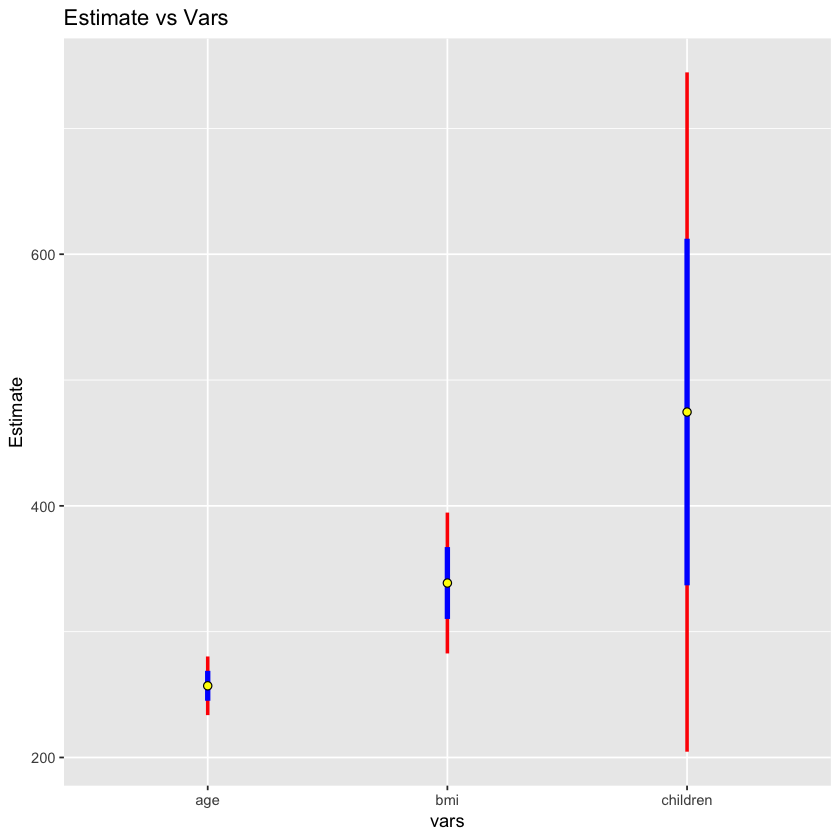

In [23]:
coefs = as.data.frame(lm.summary$coefficients[2:4,1:2]) #choose variables 2 to 4
names(coefs)[2] = "se" 
coefs$vars = rownames(coefs)
ggplot(coefs, aes(vars, Estimate)) + 
geom_errorbar(aes(ymin=Estimate - 1.96*se, ymax=Estimate + 1.96*se), lwd=1, colour="red", width=0) +
geom_errorbar(aes(ymin=Estimate - se, ymax=Estimate + se), lwd=1.5, colour="blue", width=0) +
geom_point(size=2, pch=21, fill="yellow")+
  ggtitle("Estimate vs Vars")

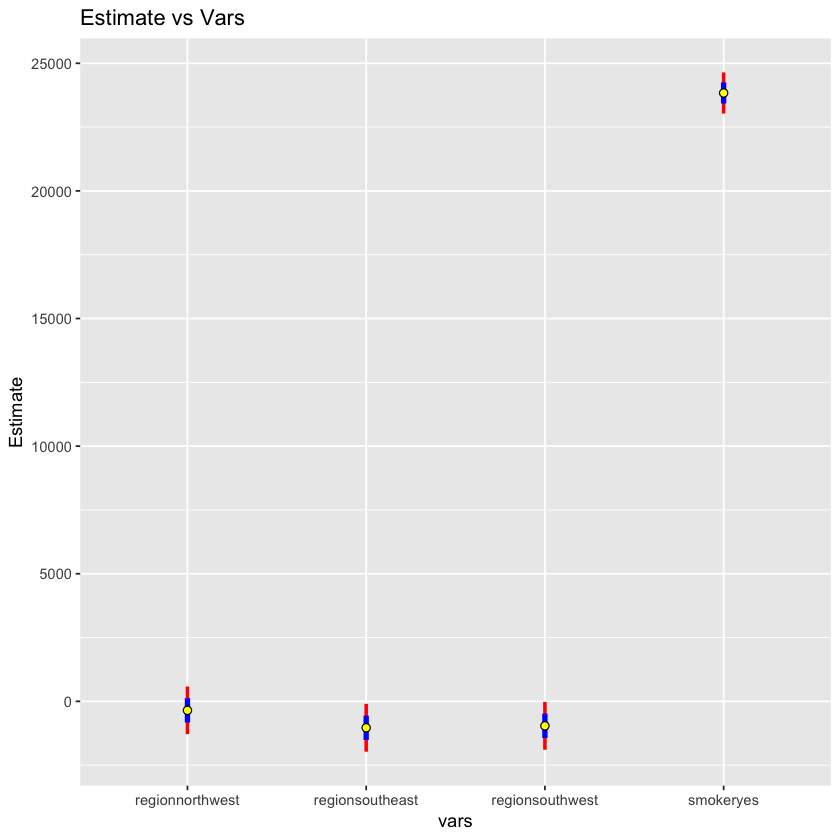

In [24]:
coefs = as.data.frame(lm.summary$coefficients[5:8,1:2]) #choose variables 2 to 4
names(coefs)[2] = "se" 
coefs$vars = rownames(coefs)
ggplot(coefs, aes(vars, Estimate)) + 
geom_errorbar(aes(ymin=Estimate - 1.96*se, ymax=Estimate + 1.96*se), lwd=1, colour="red", width=0) +
geom_errorbar(aes(ymin=Estimate - se, ymax=Estimate + se), lwd=1.5, colour="blue", width=0) +
geom_point(size=2, pch=21, fill="yellow")+
  ggtitle("Estimate vs Vars")

For both estimate vs Vars plots, the confidence intervals look good. However, Smokeryes is at a significantly higher estimate than the rest of the variables and the interval for children is much bigger than the rest of the variables.

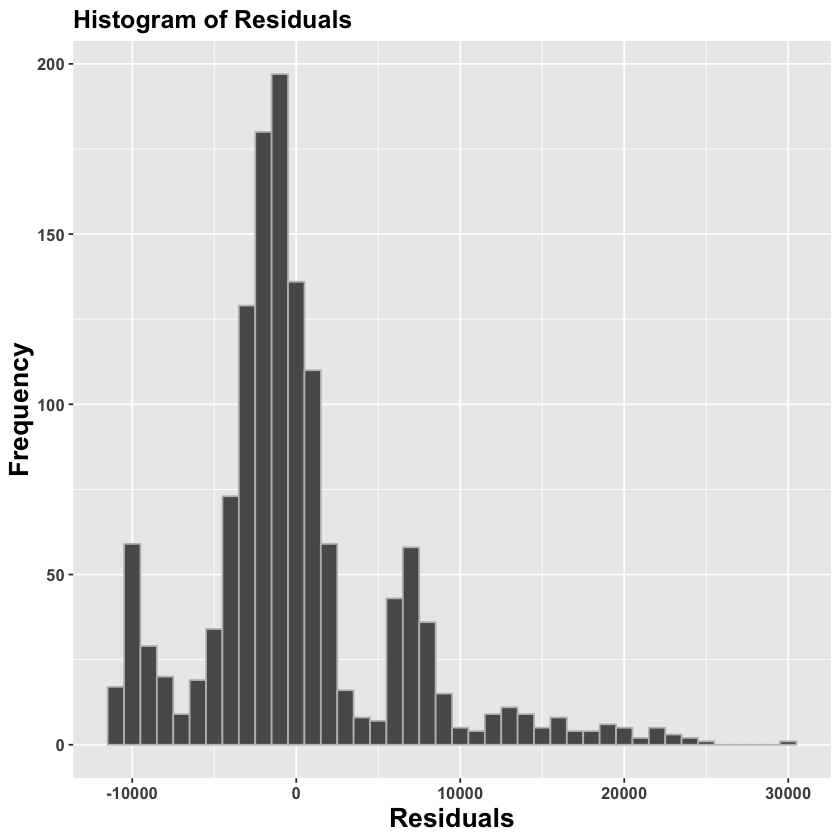

In [25]:
ggplot(insurance) +
  labs(y='Frequency', x='Residuals', title = 'Histogram of Residuals') +
 theme(axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 10, face = "bold"),
    strip.text = element_text(size = 13, face = "bold"),
    plot.title = element_text(size = 15, face = "bold")) +
  geom_histogram(aes(x=residuals(lm.fit)),binwidth = 1000, colour='grey')

The histogram of residuals shows us that the data is roughly following the normal distribution. This is good because it shows that if there were a lot more observations, the distrubtions would show a normal distribution.

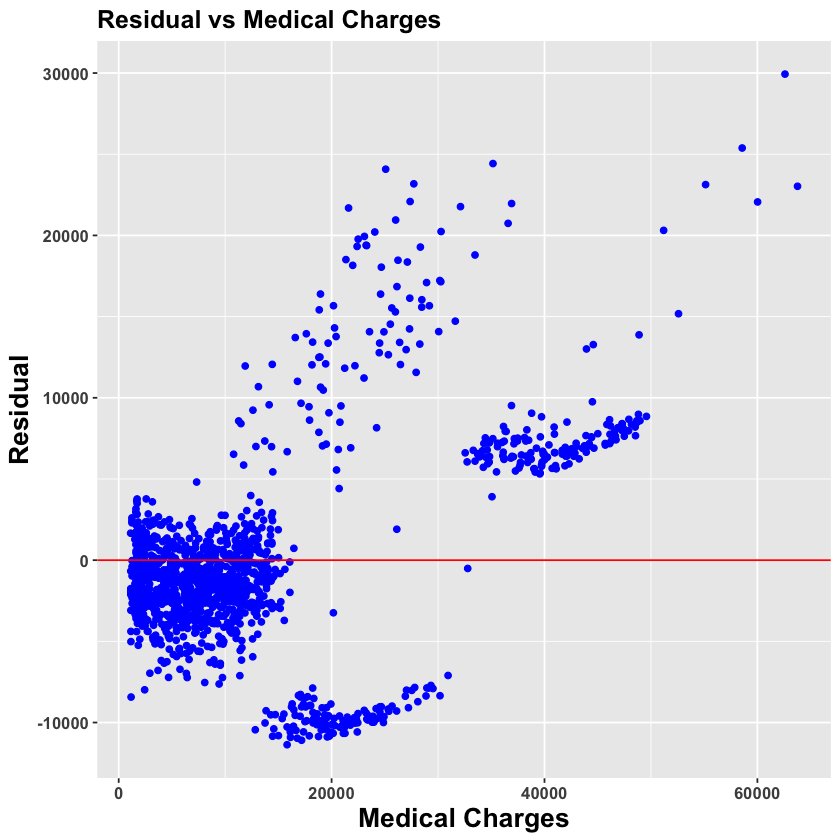

In [26]:
ggplot() +
  geom_point(aes(x=insurance$charges, y = residuals(lm.fit)),
             colour = 'blue') +
  geom_abline(intercept = 0, slope = 0,
            colour = 'red') +
    theme(axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 10, face = "bold"),
    strip.text = element_text(size = 13, face = "bold"),
    plot.title = element_text(size = 15, face = "bold")) +
  ggtitle("Residual vs Medical Charges") +
  xlab("Medical Charges") + ylab("Residual")

This residual vs medical charges plot shows that the data is not random and that we might need to use other methods other than linear regression to analysis this data.

In [27]:
set.seed(1) # remember, we need to set seed.

index = createDataPartition(insurance$smoker, p = 0.8, list = F )
train = insurance[index,]
test = insurance[-index,]

In [28]:
numbers = 10
repeats = 3
tunel = 10

In [29]:
set.seed(2)
x = trainControl(method = "repeatedcv",
                 number = numbers,
                 repeats = repeats,
                 classProbs = TRUE,
                 summaryFunction = twoClassSummary)

In [30]:
model1 <- train(smoker~. , data = train, method = "knn",
               preProcess = c("center","scale"),
               trControl = x,
               metric = "ROC",
               tuneLength = tunel)
model1

k-Nearest Neighbors 

1072 samples
   6 predictor
   2 classes: 'no', 'yes' 

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 964, 964, 965, 965, 965, 965, ... 
Resampling results across tuning parameters:

  k   ROC        Sens       Spec     
   5  0.9674732  0.9655495  0.7803030
   7  0.9709442  0.9682809  0.6984848
   9  0.9719675  0.9741496  0.6075758
  11  0.9715521  0.9831555  0.5833333
  13  0.9714830  0.9886366  0.5681818
  15  0.9687388  0.9917693  0.5606061
  17  0.9682707  0.9949065  0.5530303
  19  0.9670353  0.9952941  0.5530303
  21  0.9654099  0.9960784  0.5500000
  23  0.9641809  0.9968627  0.5530303

ROC was used to select the optimal model using the largest value.
The final value used for the model was k = 9.

The model is assessing which K is best, and it found the k=9 is the best and final value.

In [31]:
knn_pred <- predict(model1,test, type = "prob")

In [32]:
pred_val <-prediction(knn_pred[,2],test$smoker)

# Calculating Area under Curve (AUC)
perf_val <- performance(pred_val,"auc")
perf_val

An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.9814815


Slot "alpha.values":
list()


This is showing the area under the ROC Curve which is .9814815. The AUC tells about the overall performance on the model, the closer the AUC value is to 1 the better the overall performance.

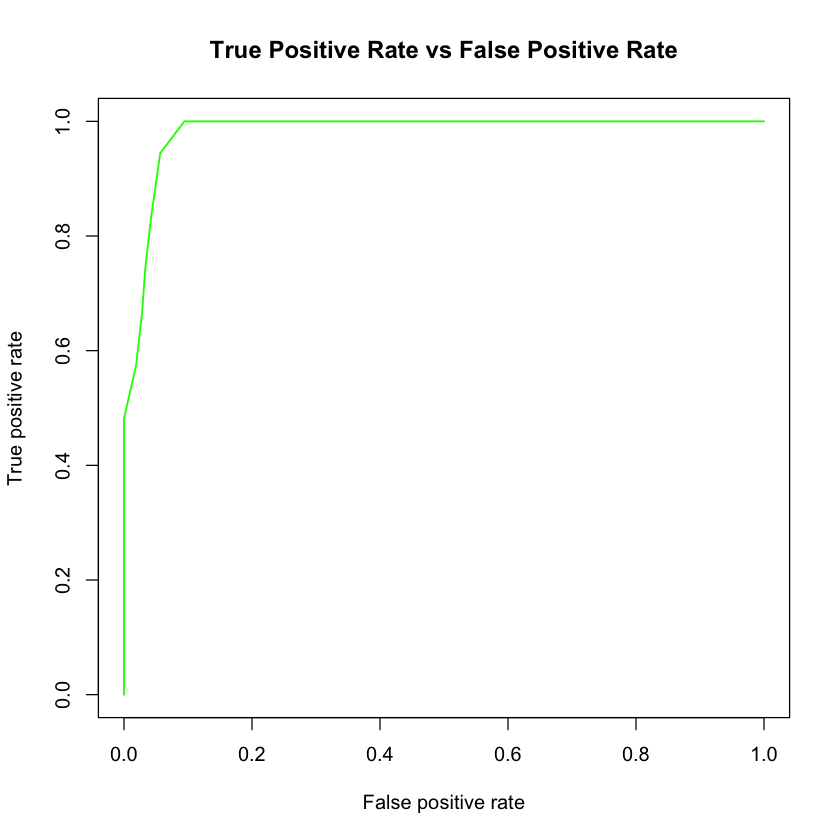

In [33]:
# Plot AUC
perf_val <- performance(pred_val, "tpr", "fpr")
plot(perf_val, col = "green", lwd = 1.5, main = "True Positive Rate vs False Positive Rate")

In [34]:
get_mse(lm.fit)

[1] 36725751

The True Positive Rate vs False Positive Rate graph shows that the there are little false postives which is good. The calculated MSE is 36725751.333074

# Ridge

In [38]:
x = model.matrix(charges~., insurance)[,-1] # trim off the first column
                                         # leaving only the predictors
y = insurance$charges

In [39]:
#Dividing the data into train and test subsets
set.seed(1) # remember, we need to set seed.

index = createDataPartition(insurance$charges, p = 0.8, list = F )
train = insurance[index,]
test = insurance[-index,]

In [40]:
x_train = model.matrix(charges~., train)[,-1] 
x_test = model.matrix(charges~., test)[,-1]
y_train = train$charges
y_test = test$charges

In [42]:
names(train)
dim(train)
head(train)
dim(test)
head(test)

[1] "age"      "sex"      "bmi"      "children" "smoker"   "region"   "charges"

[1] 1072    7

age,sex,bmi,children,smoker,region,charges
19,female,27.900,0,yes,southwest,16884.924
33,male,22.705,0,no,northwest,21984.471
32,male,28.880,0,no,northwest,3866.855
46,female,33.440,1,no,southeast,8240.590
37,male,29.830,2,no,northeast,6406.411
60,female,25.840,0,no,northwest,28923.137


[1] 266   7

age,sex,bmi,children,smoker,region,charges
18,male,33.770,1,no,southeast,1725.552
28,male,33.000,3,no,southeast,4449.462
31,female,25.740,0,no,southeast,3756.622
37,female,27.740,3,no,northwest,7281.506
18,male,34.100,0,no,southeast,1137.011
37,male,28.025,2,no,northwest,6203.902


In [43]:
# train your model on the training set, remember that we set alpha to zero for ridge and to one for lasso
ridge_mod = glmnet(x_train, y_train, alpha=0)
# predict using the trained model and your X_test set
ridge_pred = predict(ridge_mod, newx = x_test)

In [44]:
set.seed(1)
cv.out = cv.glmnet(x_train, y_train, alpha = 0) # Fit ridge regression model on training data
bestlam = cv.out$lambda.1se  # Select lamda that minimizes training MSE
bestlam

[1] 1991.827

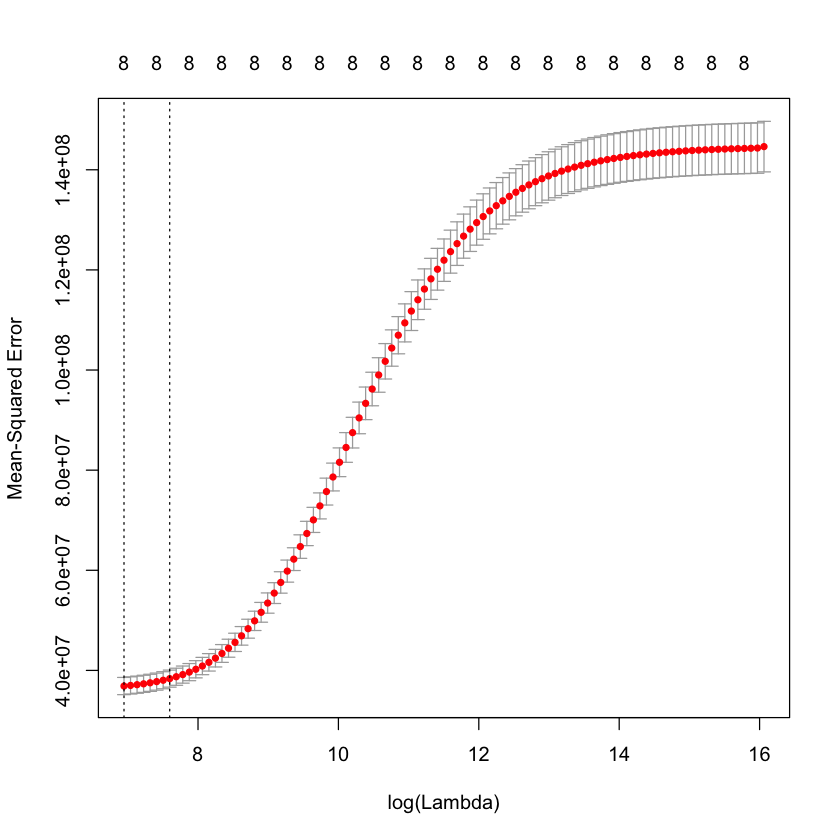

In [46]:
plot(cv.out) # Draw plot of training MSE as a function of lambda

The 1 standard error lambda is the second dashed verticle which is around 8.

In [47]:
ridge_pred = predict(ridge_mod, s = bestlam, newx = x_test) # Use best lambda to predict test data
mean((ridge_pred - y_test)^2)

[1] 44739831

The MSE for the test subset is 44739830.9942584

In [48]:
out = glmnet(x, y, alpha = 0) # Fit ridge regression model on the FULL dataset (train and test)
predict(out, type = "coefficients", s = bestlam)[1:9,] # Display coefficients using lambda chosen by CV

(Intercept)             age         sexmale             bmi        children 
    -8633.29828       220.80144        69.73456       290.59029       434.29343 
      smokeryes regionnorthwest regionsoutheast regionsouthwest 
    20414.40733      -235.50230      -462.23087      -708.34451

The coefficients have shrunk due to the chosen lambda

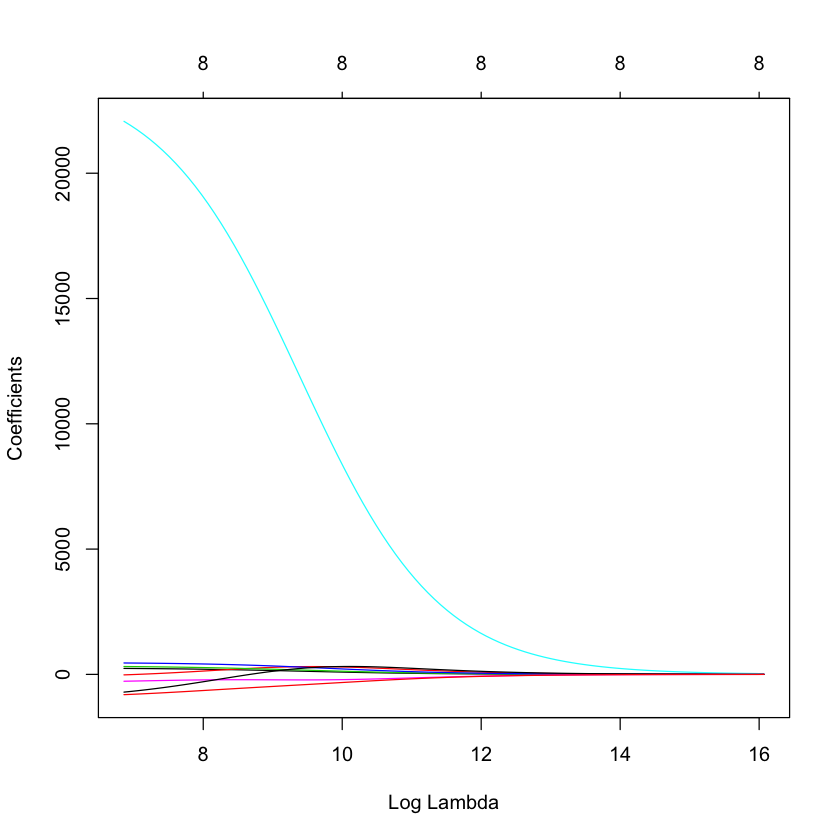

In [49]:
plot(out, xvar = "lambda")

This shows how the coefficients shrink as lambda increases.

# Lasso

[1] "a0"        "beta"      "call"      "dev.ratio" "df"        "dim"      
 [7] "jerr"      "lambda"    "nobs"      "npasses"   "nulldev"   "offset"

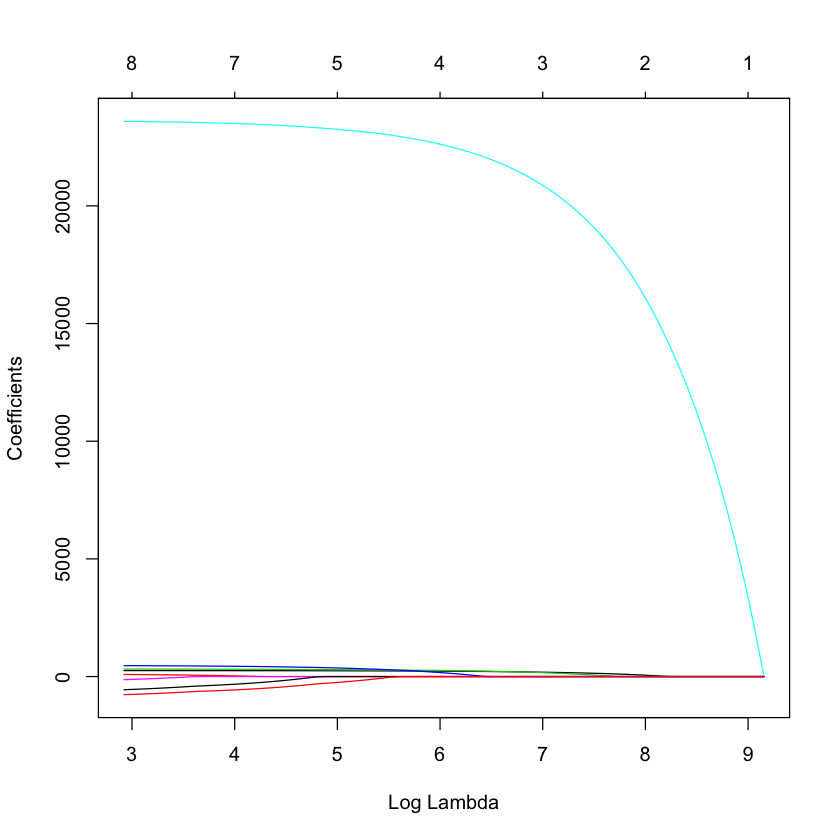

In [56]:
lasso_mod = glmnet(x_train, 
                   y_train, 
                   alpha = 1) # Fit lasso model on training data
ls(lasso_mod)
plot(lasso_mod,  xvar = "lambda")

This shows how the coefficients shrinks towards and ends up being 0 as lambda increases.

[1] 41419898

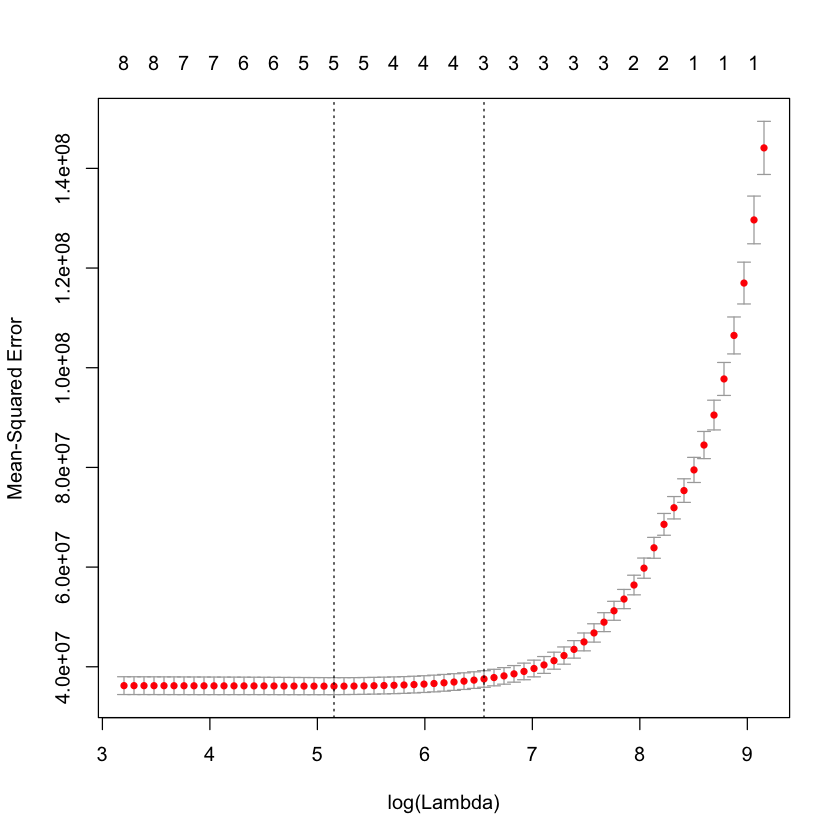

In [57]:
set.seed(1)
cv.out = cv.glmnet(x_train, y_train, alpha = 1) # Fit lasso model on training data
plot(cv.out) # Draw plot of training MSE as a function of lambda

bestlam = cv.out$lambda.min # Select lamda that minimizes training MSE
lasso_pred = predict(lasso_mod, s = bestlam, newx = x_test) # Use best lambda to predict test data
mean((lasso_pred - y_test)^2) # Calculate test MSE

The 1 standard error of the minimum lambda is around 7. Also the MSE for the test subset is 41419898.3852836

In [58]:
out = glmnet(x, y, alpha = 1) # Fit lasso model on full dataset
lasso_coef = predict(out, type = "coefficients", s = bestlam)[1:9,] # Display coefficients using lambda chosen by CV
lasso_coef

(Intercept)             age         sexmale             bmi        children 
   -10659.28186       246.82950         0.00000       298.11123       338.01002 
      smokeryes regionnorthwest regionsoutheast regionsouthwest 
    23378.58668         0.00000       -76.31204      -105.90808

In [59]:
lasso_coef[lasso_coef != 0]

(Intercept)             age             bmi        children       smokeryes 
   -10659.28186       246.82950       298.11123       338.01002     23378.58668 
regionsoutheast regionsouthwest 
      -76.31204      -105.90808

The Lasso Model shrinks the covariates and sets two variables equal to 0, which are sexmale and regionnorthwest. This makes sense because when we ran the OLS, these were the two variables that were not significant.

The test MSE for OLS is 36725751.333074. While the test MSE for Ridge is 44739830.9942584 and the test MSE for Lasso is 41419898.3852836 The test MSE of the OLS is less than the the test MSE's of the Ridge and Lasso. However, we already saw that the OLS isn't the best method of modelling the dataset because the prediction vs actual graph over/under estimates many observations.

The Lasso test MSE is less than the Ridge test MSE, which suggests that Lasso is the better method than Ridge. This is especially true because I do not think sexmale and regionnorthwest have much prediction power towards the model.

# Decision Tree

In [63]:
set.seed(1)

train = insurance %>% sample_frac(.8)
test = insurance %>% setdiff(train)

In [64]:
tree_insurance = tree(charges~., train)
summary(tree_insurance)


Regression tree:
tree(formula = charges ~ ., data = train)
Variables actually used in tree construction:
[1] "smoker" "age"    "bmi"   
Number of terminal nodes:  5 
Residual mean deviance:  22580000 = 2.405e+10 / 1065 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -8244   -2956   -1084       0    1111   23980 

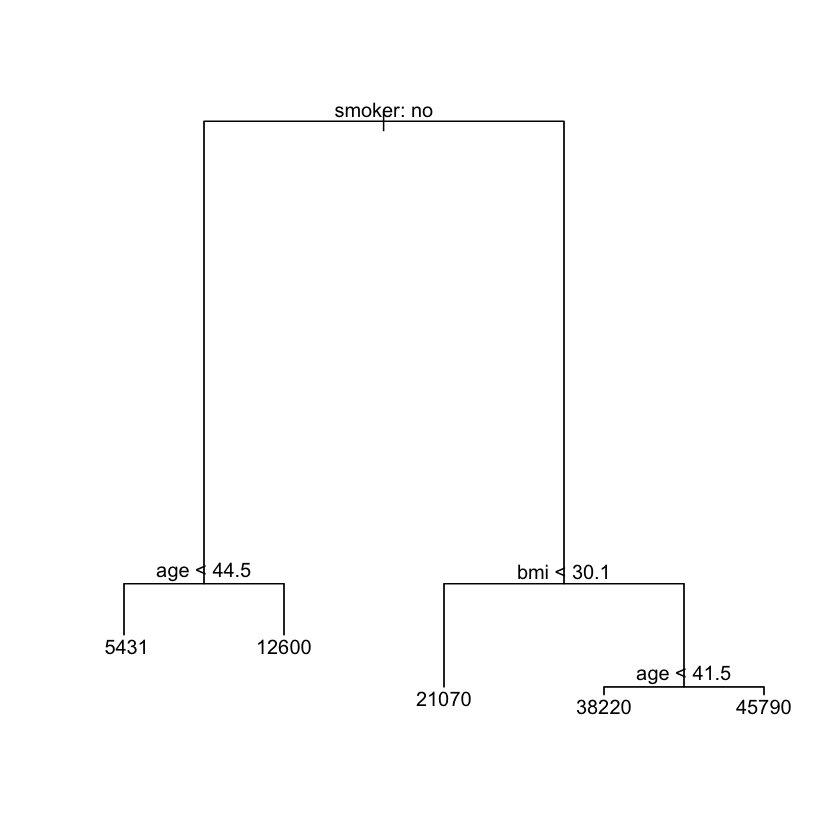

In [65]:
plot(tree_insurance)
text(tree_insurance, pretty = 0)

In [66]:
#The breakdown of splits for the tree above
tree_insurance

node), split, n, deviance, yval
      * denotes terminal node

 1) root 1070 1.548e+11 13050  
   2) smoker: no 862 3.025e+10  8374  
     4) age < 44.5 508 9.901e+09  5431 *
     5) age > 44.5 354 9.633e+09 12600 *
   3) smoker: yes 208 2.776e+10 32410  
     6) bmi < 30.1 93 2.289e+09 21070 *
     7) bmi > 30.1 115 3.854e+09 41580  
      14) age < 41.5 64 9.916e+08 38220 *
      15) age > 41.5 51 1.234e+09 45790 *

This regression tree suggests that smoker is the most important covariate followed by age and bmi. The tree indicates that individuals who are not smokers and are less than 44.5 years in age will have 8374 in medical charges while individuals over 44.5 years in age will have 12600 in medical charges.

The tree also indicates that individuals who are smokers have greater medical charges than nonsmokers. Such as smokers that also have less than 30.1 bmi have 21070 in medical charges. Smokers that have greater than 30.1 bmi and are less than 41.5 years in age have 38220 in medical charges. And smokers that have greater than 30.0625 bmi and are greater than 41.5 years in age have 45790 in medical charges.

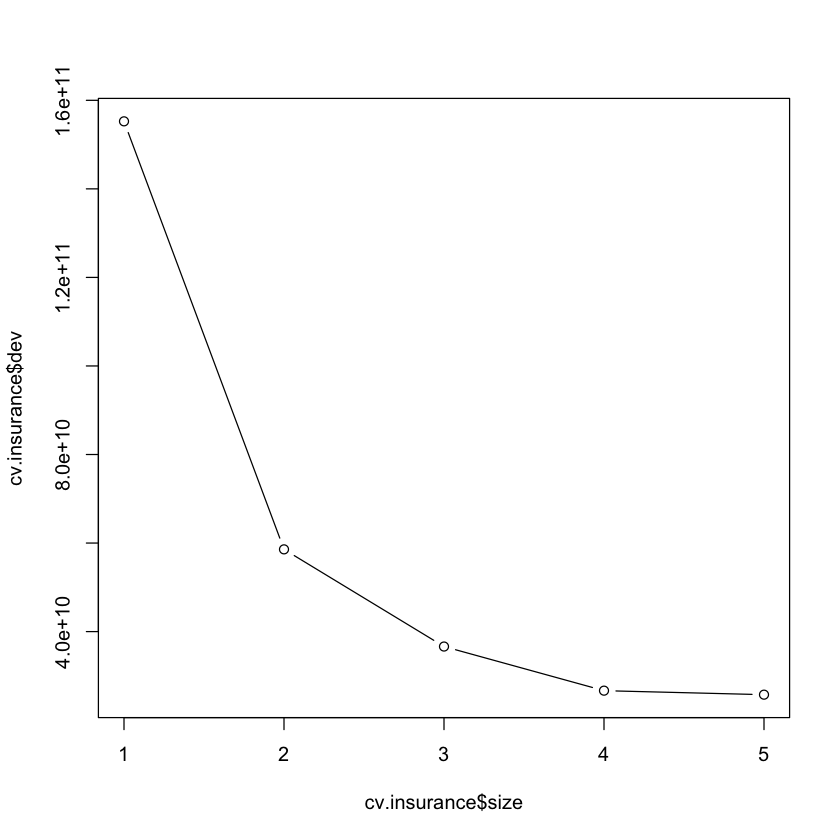

In [67]:
cv.insurance = cv.tree(tree_insurance)
plot(cv.insurance$size, cv.insurance$dev, type = 'b')

The 5-node tree is seleced by cross-validation.

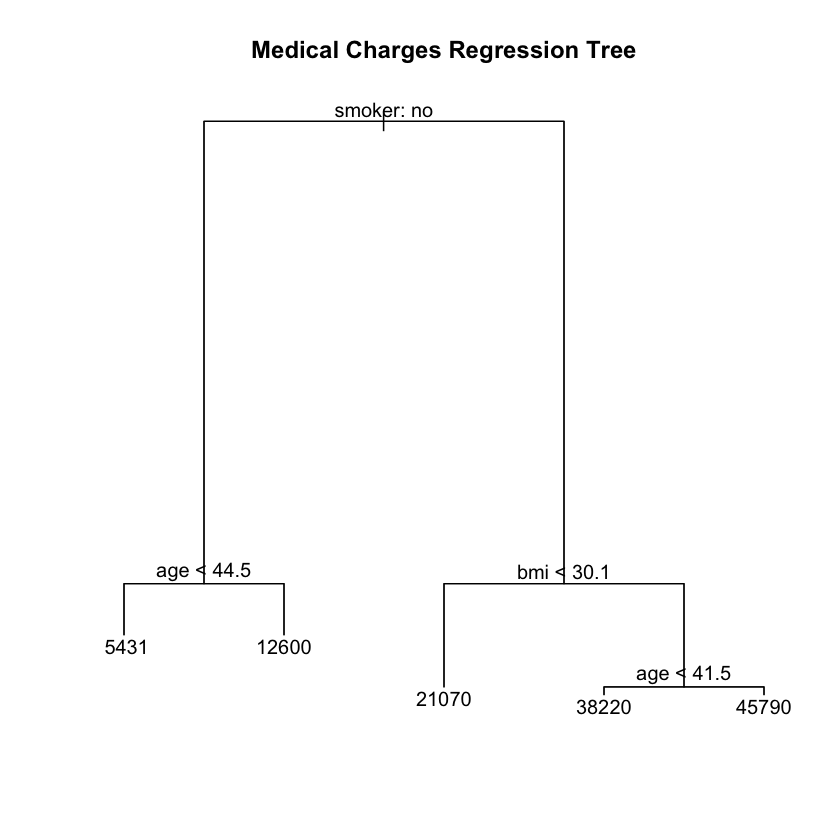

In [68]:
prune_insurance = prune.tree(tree_insurance, best = 5)
plot(prune_insurance)
text(prune_insurance, pretty = 0)
title("Medical Charges Regression Tree")

This is the regression tree because the pruning method selected 5-nodes which all the variables in the previous tree.

This regression tree suggests that smoker is the most important covariate followed by age and bmi. The tree indicates that individuals who are not smokers and are less than 44.5 years in age will have 8374 in medical charges while individuals over 44.5 years in age will have 12600 in medical charges.

The tree also indicates that individuals who are smokers have greater medical charges than nonsmokers. Such as smokers that also have less than 30.1 bmi have 21070 in medical charges. Smokers that have greater than 30.1 bmi and are less than 41.5 years in age have 38220 in medical charges. And smokers that have greater than 30.0625 bmi and are greater than 41.5 years in age have 45790 in medical charges.

[1] 30816058

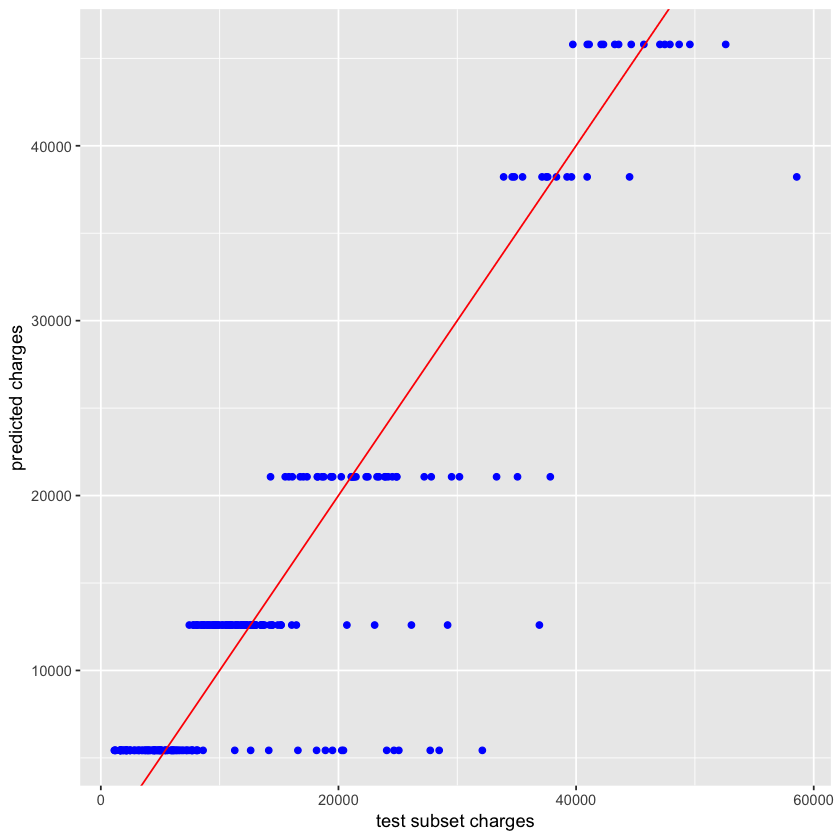

In [71]:
single_tree_estimate = predict(prune_insurance, 
                               newdata = test)

ggplot() + 
    geom_point(aes(x = test$charges, y = single_tree_estimate), color = 'blue') +
    geom_abline(color = 'red')+
    labs(x='test subset charges' , y= 'predicted charges')

mean((single_tree_estimate - test$charges)^2)

In other words, the test set MSE associated with the regression tree is 30816058.0168019. The square root of the MSE is therefore around 5551.22, indicating that this model leads to test predictions that are within around $ 5551220 of the true medical charges.

In [72]:
lm_insurance=lm(charges~., train)
lm_estimate = predict(lm_insurance, newdata = test)
mean((lm_estimate - test$charges)^2)

[1] 44820026

In [73]:
for (i in c(1:10)){
set.seed(i)
train = insurance %>%
  sample_frac(.8)

test = insurance %>%
  setdiff(train)
tree_insurance=tree(charges~., train)
prune_insurance = prune.tree(tree_insurance, 
                          best = 5)
single_tree_estimate = predict(prune_insurance, 
                               newdata = test)
print(mean((single_tree_estimate - test$charges)^2))
    
}

[1] 30816058
[1] 23286210


Warning message in prune.tree(tree_insurance, best = 5):
“best is bigger than tree size”

[1] 27416316
[1] 24976843


Warning message in prune.tree(tree_insurance, best = 5):
“best is bigger than tree size”

[1] 27404801


Warning message in prune.tree(tree_insurance, best = 5):
“best is bigger than tree size”

[1] 27658318


Warning message in prune.tree(tree_insurance, best = 5):
“best is bigger than tree size”

[1] 26499976


Warning message in prune.tree(tree_insurance, best = 5):
“best is bigger than tree size”

[1] 29623607
[1] 27406648


Warning message in prune.tree(tree_insurance, best = 5):
“best is bigger than tree size”

[1] 27851347


For the 10 different samples, a lambda of 5 is bigger than the tree size for six of the samples. This means that for those samples, the tree sizes must have only had 4-nodes or less. The test MSE for the regression tree is 30816058.0168019 and the test MSE of the linear model is 44820026.2889436. This suggests that the performance of he regression tree is better than the linear model because the test MSE is lower.

The test MSE of the Ridge model is 44739830.9942584 and the test MSE of the Lasso model is 41419898.3852836. The test MSE of the regression tree is also lower than these two methods which suggests that the performance of the regression tree is better than the Ridge and Lasso models.

# Bagging

In [77]:
#split to train and test
set.seed(1)
insurance_train = insurance %>% sample_frac(.8)

insurance_test = insurance %>% setdiff(insurance_train)

In [78]:
set.seed(1)
bag.insurance = randomForest(charges ~., data=insurance_train, 
                          mtry=ncol(insurance_train)-1, 
                          importance=TRUE) 
bag.insurance


Call:
 randomForest(formula = charges ~ ., data = insurance_train, mtry = ncol(insurance_train) -      1, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 21532752
                    % Var explained: 85.12

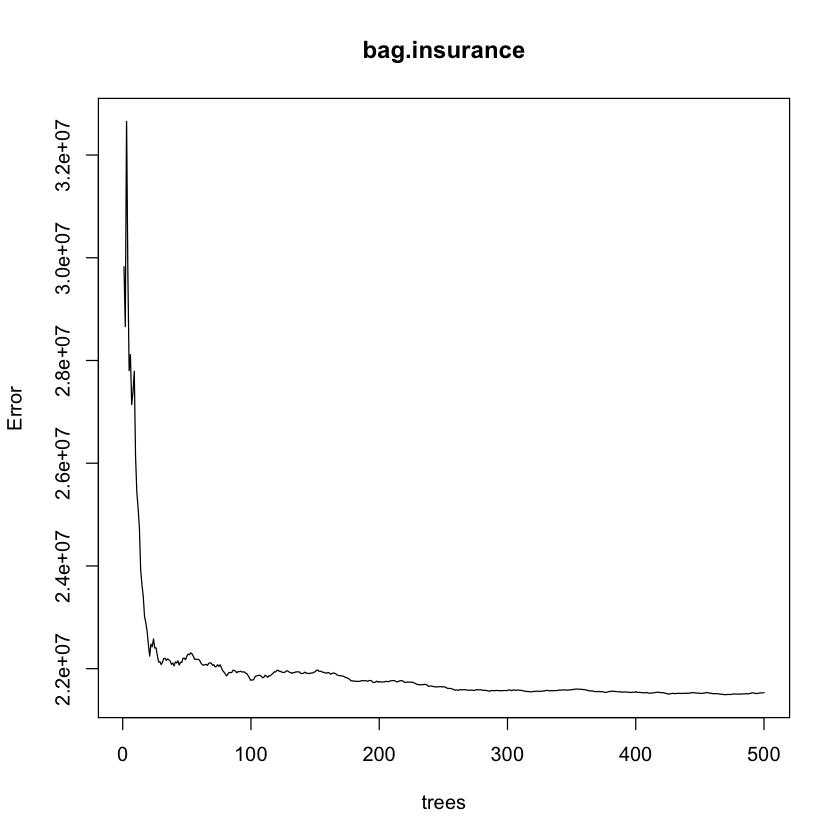

In [79]:
plot(bag.insurance)

This is a plot of the out-of-bag error rate as a function of number of trees. It shows that the error rate sharply decreases as the number of trees increases towards around 20. Then the error rate begins to slowly decrease and fluctuates as the number of trees increases towards 500.

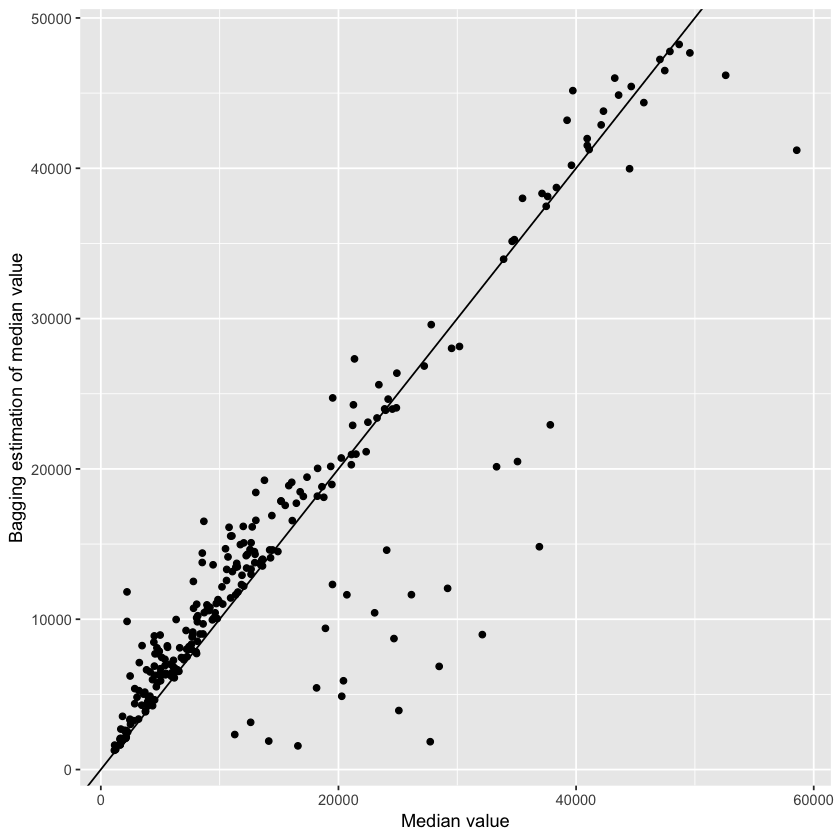

In [80]:
yhat.bag = predict(bag.insurance, 
                          newdata = insurance_test)

ggplot() + 
    geom_point(aes(x = insurance_test$charges, y = yhat.bag)) +
    geom_abline()+
    labs(x="Median value", y="Bagging estimation of median value")

This is the predicted vs actual graph. It shows from roughly 0 to 19000 on the x axis, the prediction is underestimating the actual values. And the prediction is also overestimating many values throughout the whole graph. However, this predicted vs actual graph is still much better than the predicted vs actual graph from the second report.

In [81]:
round(mean((yhat.bag-insurance_test$charges)^2),2)

[1] 26645124

The test set MSE associated with the bagged regression tree is 26645123.9.

The test MSE for OLS is 36725751.333074. While the test MSE for Ridge is 44739830.9942584 and the test MSE for Lasso is 41419898.3852836

The test set MSE for Bagging is about half less than those obtained from Lasso and Ridge. It is also less than the MSE from the MSE obtained from OLS. So out of these methods, bagging seems to be the best method

In [82]:
bag.insurance = randomForest(charges ~., data=insurance_train, mtry = ncol(insurance_train)-1, ntree=25)
yhat.bag = predict(bag.insurance, newdata=insurance_test)
round(mean((yhat.bag-insurance_test$charges)^2),2)

[1] 26149295

In [83]:
importance(bag.insurance)

,IncNodePurity
age,20088291076
sex,581231257
bmi,29985026061
children,2414753573
smoker,95798446302
region,2044098946


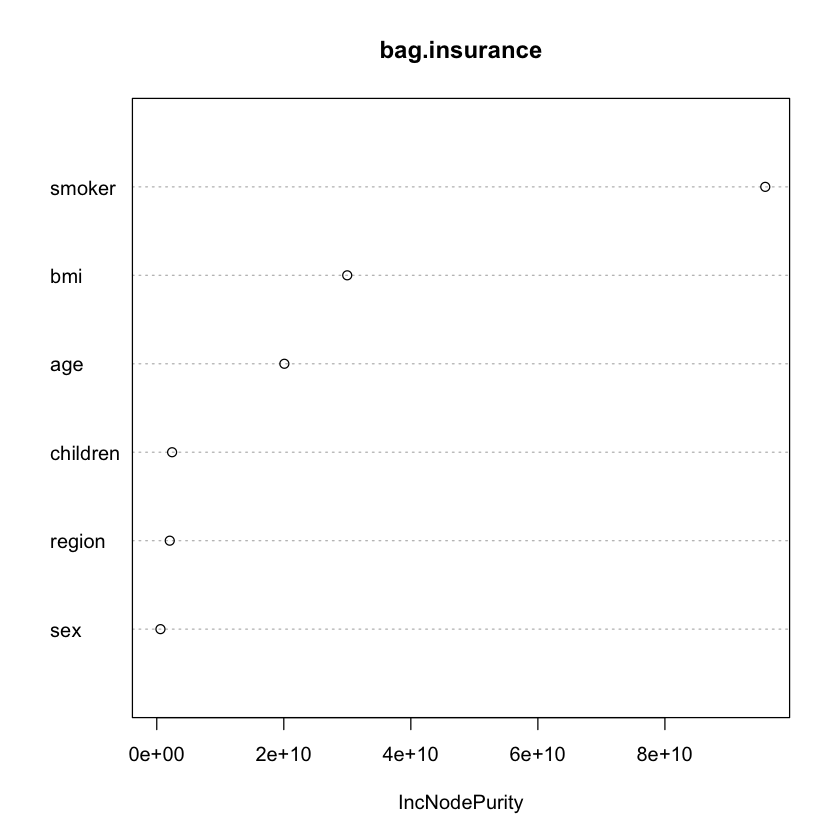

In [84]:
varImpPlot(bag.insurance)

This is the importance matrix which shows which variables are the most important. The importance of the variables are in the order of smoker, bmi, age, children, region, then sex.

# Random Forest

In [87]:
# Set mtry using hyperparamter tuning

oob.err<-double(6)
test.err<-double(6)

#mtry is no of Variables randomly chosen at each split
for(mtry in 1:6) 
{
  rf=randomForest(charges ~ . , data = insurance_train, mtry=mtry, ntree=400) 
  oob.err[mtry] = rf$mse[400] #Error of all Trees fitted on training
  
  pred<-predict(rf, insurance_test) #Predictions on Test Set for each Tree
  test.err[mtry]= with(insurance_test, mean( (charges - pred)^2)) # "Test" Mean Squared Error
  
 # print(mtry)
  
}

In [88]:
round(test.err ,2) #what `mtry` do you use based on test error?

[1] 48611728 26576305 25757737 26074593 26200808 26574635

The best mtry is 3 because it has the lowest MSE

In [89]:
round(oob.err,2)

[1] 43504454 21275227 20336165 20423963 20989168 21583436

The best out-of-bag error is the third one.

In [90]:
set.seed(1)
rf.insurance = randomForest(charges~., 
                         data = insurance_train, 
                         mtry = 3, 
                         importance = TRUE,
                         do.trace = 100) #do.trace gives you the OOB MSE for every 100 trees

yhat.rf = predict(rf.insurance, newdata = insurance_test)

round(mean((yhat.rf - insurance_test$charges)^2),2)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 100 | 2.091e+07    14.45 |
 200 | 2.049e+07    14.16 |
 300 | 2.035e+07    14.07 |
 400 | 2.036e+07    14.07 |
 500 | 2.034e+07    14.06 |


[1] 25668956

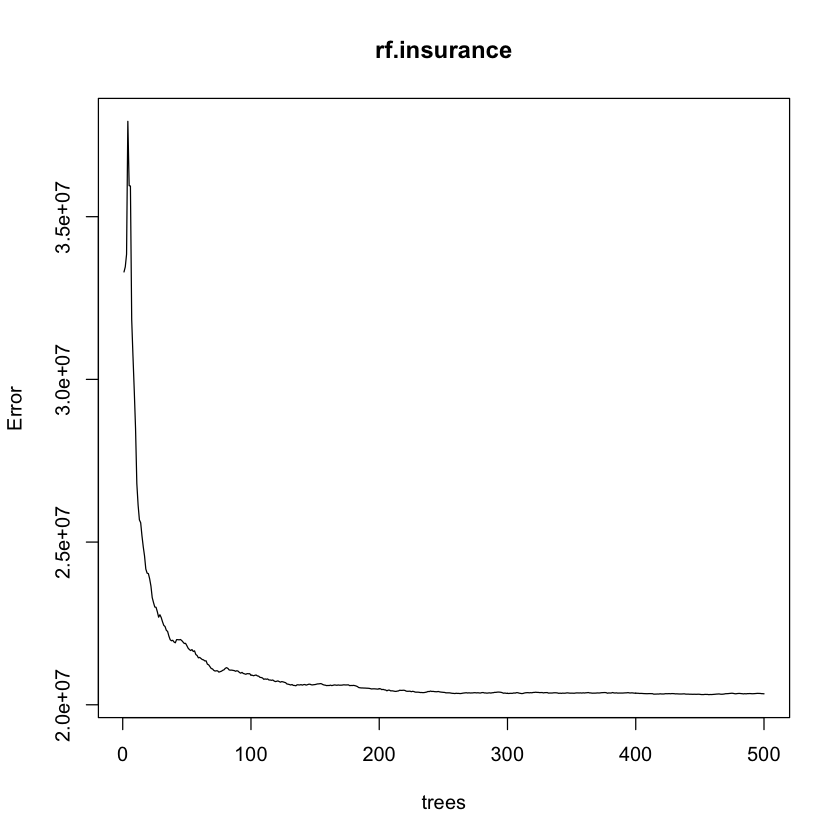

In [91]:
plot(rf.insurance)

This is a plot of the out-of-bag error rate as a function of number of trees. It shows that the error rate sharply decreases as the number of trees increases towards around 20. Then the error rate begins to slowly decrease until around 150 trees and then the error rate begins the flatten out.

The test set MSE is even lower; this indicates that Random Forest yielded an improvement over bagging in this case.

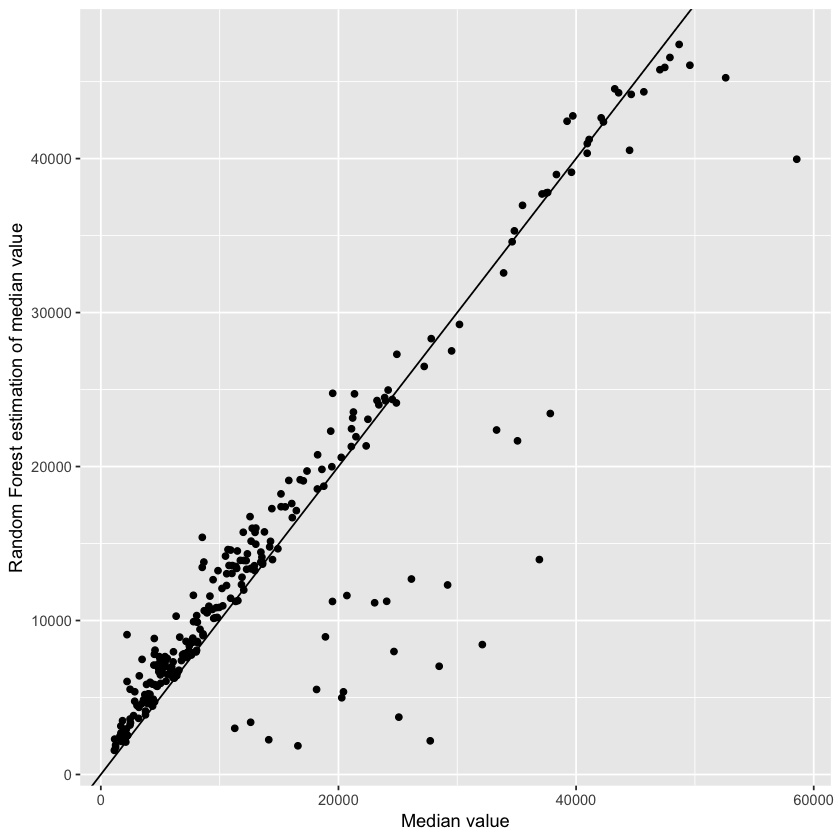

In [92]:
yhat.rf = predict(rf.insurance, 
                          newdata = insurance_test)

ggplot() + 
    geom_point(aes(x = insurance_test$charges, y = yhat.rf)) +
    geom_abline()+
    labs(x="Median value", y="Random Forest estimation of median value")


This is the predicted vs actual graph. It shows that the prediction is underestimating most of the actual values from 0 to around 21000 on the x axis. And the prediction is also overestimating many values throughout the whole graph.

In [93]:
round(mean((yhat.rf-insurance_test$charges)^2),2)

[1] 25668956

The test set MSE assoiated with the random forest is 25668956.15.

The test set MSE for the bagged regression tree is 26645123.9. The test MSE for OLS is 36725751.333074. While the test MSE for Ridge is 44739830.9942584 and the test MSE for Lasso is 41419898.3852836

The test set MSE for random forest is lower than that obtained by Bagging. It is about half less than those obtained from Lasso and Ridge. It is also less than the MSE from the MSE obtained from OLS. So out of these methods, random forest seems to be the best method

In [94]:
importance(rf.insurance)

,%IncMSE,IncNodePurity
age,108.2973989,21263682775
sex,0.4597825,903368184
bmi,97.8191869,24097805450
children,12.4549323,2833681108
smoker,201.3855695,98178490124
region,4.5930217,2754361546


This is the importance matrix which shows which variables are the most important. The importance of the variables are in the order of smoker, age, bmi, children, region, then sex.

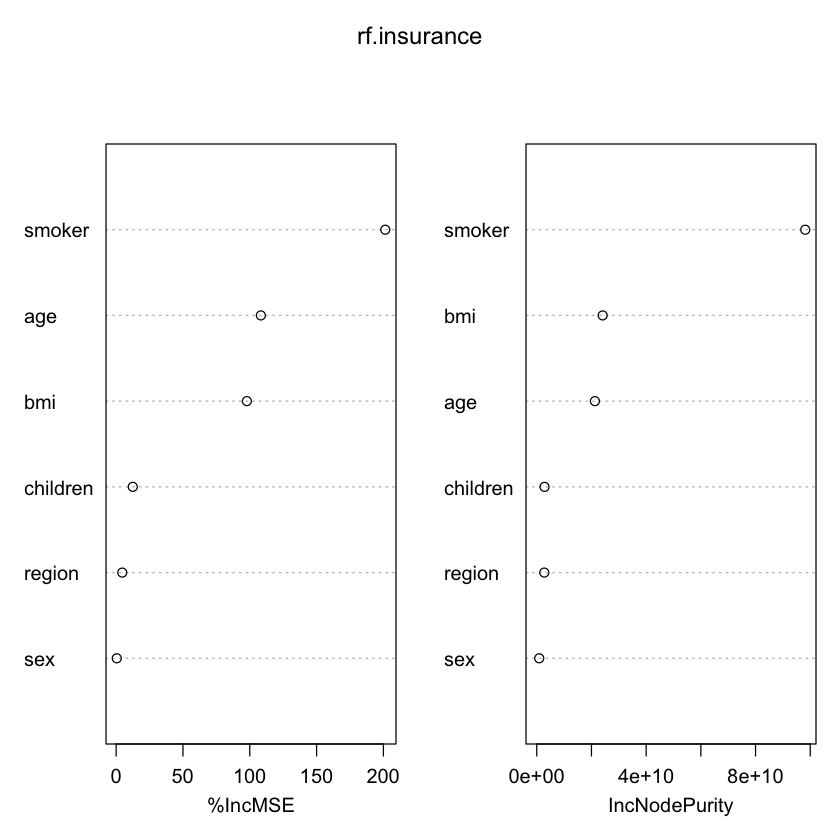

In [96]:
varImpPlot(rf.insurance)

The results indicate that across all of the trees considered in the random forest, whether an individual is a smoker or non-smoker is by far the two most important variables and followed by age and bmi.

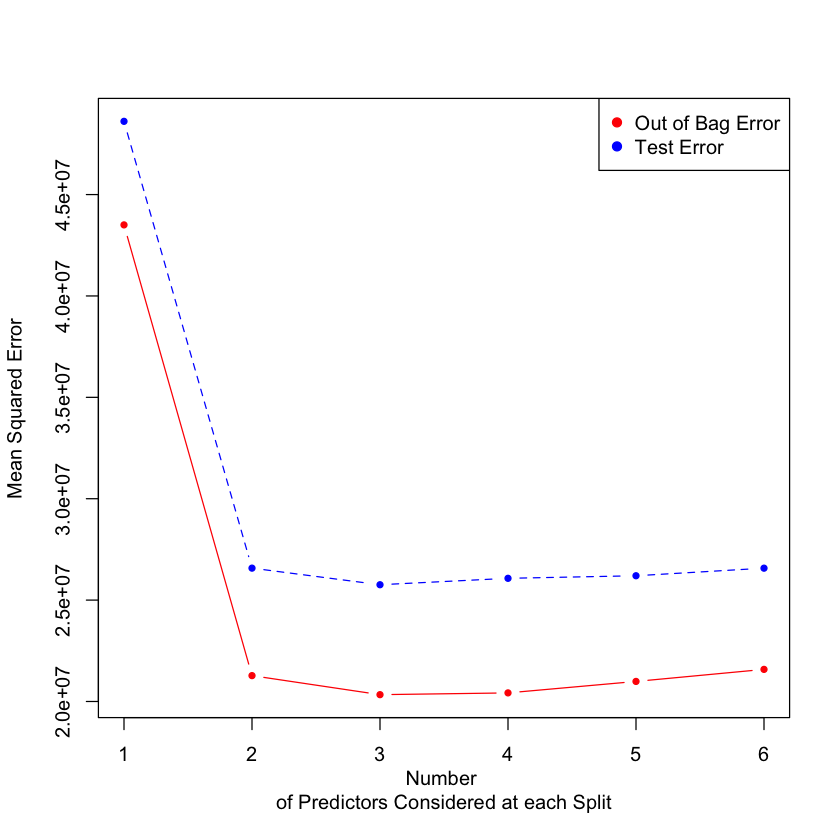

In [98]:
matplot(1:mtry , cbind(oob.err,test.err), pch=20 , col=c("red","blue"),type="b",ylab="Mean Squared Error",xlab="Number 
of Predictors Considered at each Split")

legend("topright",legend=c("Out of Bag Error","Test Error"),pch=19, col=c("red","blue"))

This is a plot two error rates to visualize the best number of variables and according to the graph, 3 is the best number of predictors for each split.

# Boosting

In [101]:
set.seed(1)
insurance_train = insurance %>% sample_frac(.8)

insurance_test = insurance %>% setdiff(insurance_train)
boost.insurance = gbm(charges~., 
                   data = insurance_train, 
                   distribution = "gaussian", 
                   n.trees = 5000, 
                   interaction.depth = 4)

,var,rel.inf
smoker,smoker,35.414745
bmi,bmi,32.046601
age,age,20.804602
region,region,5.926329
children,children,4.169394
sex,sex,1.638329


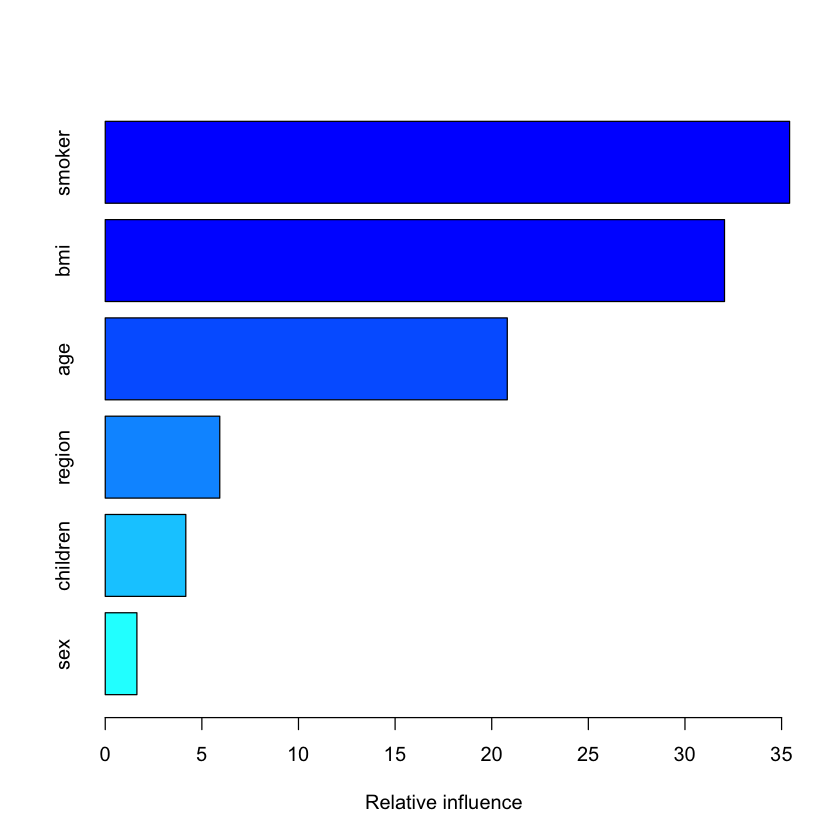

In [102]:
summary(boost.insurance)

We see that smoker followed by bmi and age are again the most important variables by far. This is different from the previous importance matrixes from the other methods which usually has smoker as the most important variable.

In [103]:
set.seed(1)
yhat.boost <- gbm(charges~., data = insurance_train,
                    distribution = "gaussian",
                    n.trees=5000,
                    interaction.depth=4,
                    shrinkage = 0.01,
                    verbose=F)

yhat.boost <- predict(yhat.boost, insurance_test, n.trees=5000)
mean((yhat.boost-insurance_test$charges)^2)

[1] 27408900

The MSE is 27408899.9697613

[1] 481

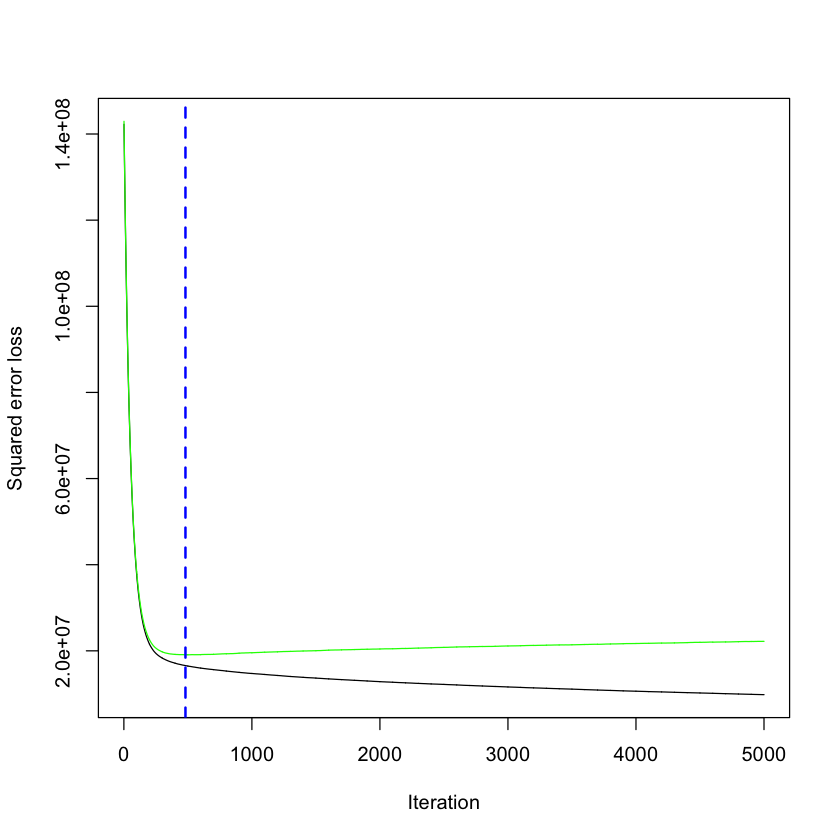

In [104]:
set.seed(1)
insurance.boost.cv <- gbm(charges~., data = insurance_train,
                       distribution = "gaussian",
                       n.trees=5000,
                       interaction.depth=4,
                       shrinkage = 0.01,
                       verbose=F,
                       cv.folds=5)
bestTreeForPrediction <- gbm.perf(insurance.boost.cv) #GBM performance stimates the optimal number of boosting iterations 
bestTreeForPrediction

The black line is the training RMSE and the green line is the cross-validation RMSE. The blue dotted line shows the best number of trees.

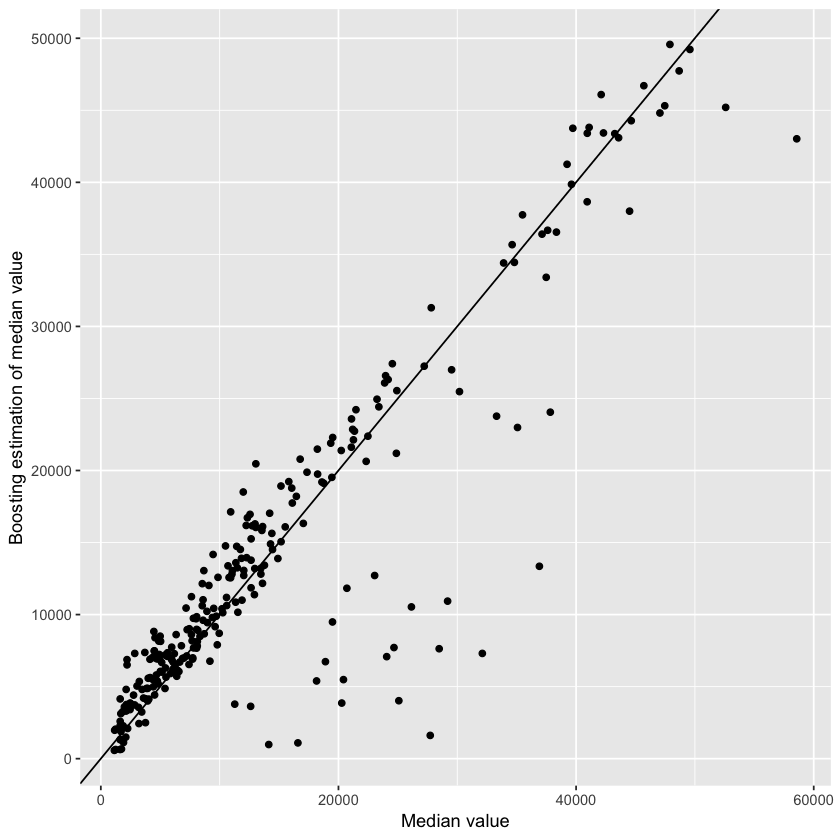

In [105]:
yhat.boost = predict.gbm(boost.insurance, 
                        newdata = insurance_test,
                        n.trees=481)

ggplot() + 
    geom_point(aes(x = insurance_test$charges, y = yhat.boost)) +
    geom_abline()+
    labs(x="Median value", y="Boosting estimation of median value")

This is the predicted vs actual graph. It shows that the prediction is following the actual values somewhat well and it is also much better than any other predicted vs actual graph I have plotted before.

In [106]:
set.seed(1)
yhat.boost <- gbm(charges~., data = insurance_train,
                    distribution = "gaussian",
                    n.trees=481,
                    interaction.depth=4,
                    shrinkage = 0.01,
                    verbose=F)

yhat.boost <- predict(yhat.boost, insurance_test, n.trees = 481)
mean((yhat.boost-insurance_test$charges)^2)

[1] 24883811

The test MSE for Boosting after cross-validation is 24883811.3586755 which is less than the MSE we got before.

The test set MSE assoiated with the random forest is 25668956.15. The test set MSE for the bagged regression tree is 26645123.9. The test MSE for OLS is 36725751.333074. While the test MSE for Ridge is 44739830.9942584 and the test MSE for Lasso is 41419898.3852836.

The test MSE for Boosting is less than those obtained by OLS, Lasso, Ridge, Bagging, and Random Forest. So out of these methods, Boosting seems to be the best method.

# XGBoost

In [109]:
Y_train <- as.matrix(insurance_train[,"charges"])
X_train <- as.matrix(insurance_train[!names(insurance_train) %in% c("charges")])
X_train <- data.frame(X_train)
X_train <- data.matrix(X_train)
dtrain <- xgb.DMatrix(data = X_train, label = Y_train)
X_test <- as.matrix(insurance_test[!names(insurance_train) %in% c("charges")])
X_test <- data.frame(X_test)
X_test <- data.matrix(X_test)

In [110]:
set.seed(1)
insurance.xgb = xgboost(data=dtrain,
                     max_depth=5,
                     eta = 0.1,
                     nrounds=40, # max number of boosting iterations (trees)
                     lambda=0,
                     print_every_n = 10,
                     objective="reg:linear") # for classification: objective = "binary:logistic"

[1]	train-rmse:16065.569336 
[11]	train-rmse:6680.659668 
[21]	train-rmse:4111.614258 
[31]	train-rmse:3482.184326 
[40]	train-rmse:3292.891846 


In [111]:
yhat.xgb <- predict(insurance.xgb, X_test)
round(mean((yhat.xgb - insurance_test$charges)^2),2)

[1] 68964462

In [112]:
set.seed(1)
param <- list("max_depth" = 5, "eta" = 0.1, "objective" = "reg:linear", "lambda" = 0)
cv.nround <- 500
cv.nfold <- 5
insurance.xgb.cv <- xgb.cv(param=param, data = dtrain,
                        nfold = cv.nfold,
                        nrounds=cv.nround,
                        early_stopping_rounds = 20 # training will stop if performance doesn't improve for 20 rounds from the last best iteration
                        )

[1]	train-rmse:16060.853711+285.136214	test-rmse:16033.848633+1141.629733 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 20 rounds.

[2]	train-rmse:14556.760547+255.651474	test-rmse:14552.183008+1014.352349 
[3]	train-rmse:13212.024414+229.109193	test-rmse:13235.058594+905.222928 
[4]	train-rmse:12012.192383+204.890506	test-rmse:12064.670703+814.338569 
[5]	train-rmse:10942.256445+183.308322	test-rmse:11026.807617+725.622810 
[6]	train-rmse:9988.943945+162.510823	test-rmse:10101.225391+652.924999 
[7]	train-rmse:9141.972461+145.038501	test-rmse:9289.784180+584.543671 
[8]	train-rmse:8387.785351+129.736641	test-rmse:8571.871582+527.968071 
[9]	train-rmse:7723.493067+115.757242	test-rmse:7950.433691+483.990284 
[10]	train-rmse:7138.065430+104.877857	test-rmse:7411.592578+440.449026 
[11]	train-rmse:6623.178516+95.221265	test-rmse:6946.412012+411.314328 
[12]	train-rmse:6171.034375+86.157637	test-rmse:6550.427539+38

In [113]:
insurance.xgb.cv$best_iteration

[1] 35

The best iteration is 35

In [114]:
insurance.xgb = xgboost(param=param, data=dtrain,,
                     nrounds=insurance.xgb.cv$best_iteration,
                     print_every_n = 10)

[1]	train-rmse:16065.569336 
[11]	train-rmse:6680.659668 
[21]	train-rmse:4111.614258 
[31]	train-rmse:3482.184326 
[35]	train-rmse:3378.010742 


In [115]:
yhat.xgb <- predict(insurance.xgb,X_test)
round(mean((yhat.xgb - insurance_test$charges)^2),2)

[1] 70148809

The test MSE for XGBoost is 70148809.07. This is greater than the test MSE obtained from Boosting which was 24883811.3586755.

The test set MSE assoiated with the random forest is 25668956.15. The test set MSE for the bagged regression tree is 26645123.9. The test MSE for OLS is 36725751.333074. While the test MSE for Ridge is 44739830.9942584 and the test MSE for Lasso is 41419898.3852836.

The test MSE for XGBoosting is greater than the test MSE obtained from Boosting which was 24883811.3586755. And it is greater than those obtained by OLS, Lasso, Ridge, Bagging, and Random Forest. So out of these methods, Boosting seems to be the best method.

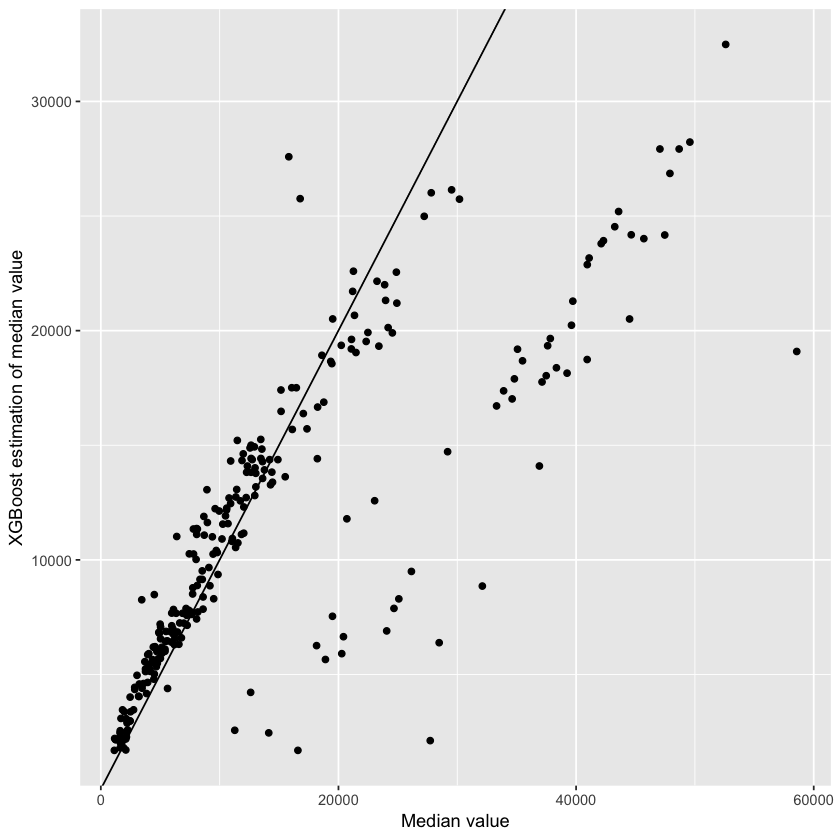

In [116]:
yhat.xgb = predict(insurance.xgb, 
                        newdata = X_test)

ggplot() + 
    geom_point(aes(x = insurance_test$charges, y = yhat.xgb)) +
    geom_abline()+
    labs(x="Median value", y="XGBoost estimation of median value")

This is the predicted vs actual graph is much different from the rest of the predicted vs actual graph that we plotted previously. It shows that the prediction is underestimating most of the actual values from 0 to around 8000 on the x axis. And the prediction is also overestimating many values throughout the whole graph.

In [117]:
importance <- xgb.importance(colnames(X_train),model=insurance.xgb)
importance

Feature,Gain,Cover,Frequency
smoker,0.677884882,0.20003739,0.03339695
bmi,0.182385030,0.28115803,0.40935115
age,0.124470062,0.36332025,0.35877863
children,0.010081368,0.08201800,0.09732824
region,0.004147261,0.05406618,0.06583969
sex,0.001031398,0.01940015,0.03530534


This importance matrix shows that the variables that are the most important go in order of smoker, bmi, age, children, region, and then sex.

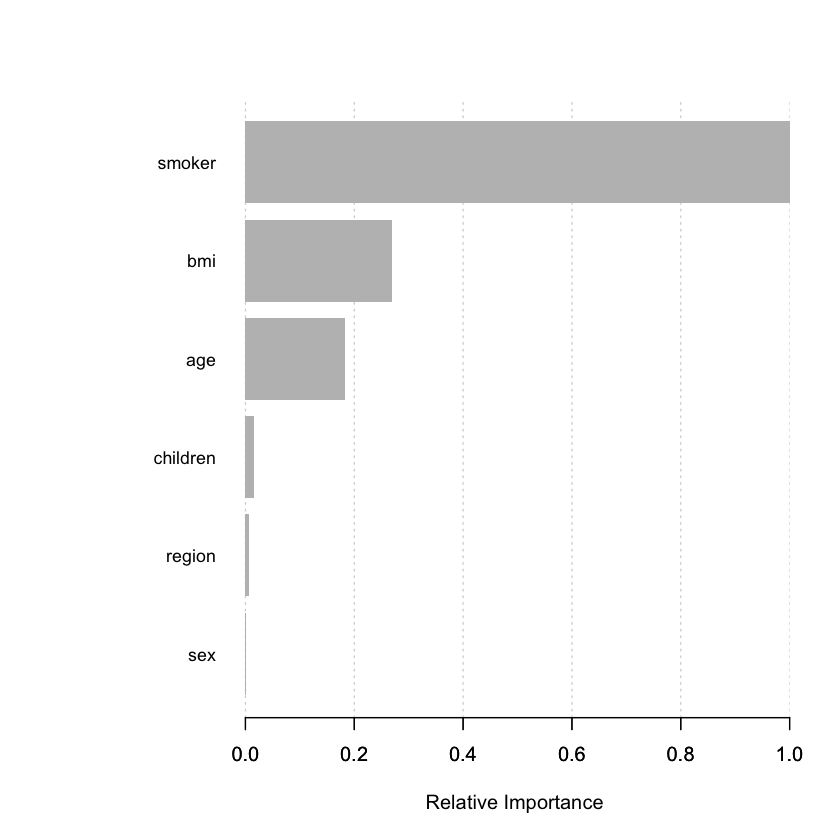

In [118]:
xgb.plot.importance(importance, rel_to_first=TRUE, xlab="Relative Importance")

This is another illustration of looking at which variables are most important which also go in the order of smoker, bmi, age, children, region, and then sex.

# Neural Network

In [121]:
# Changing variables to dummy variables in order to run Neural Network
insurance$sex <- as.numeric(insurance$sex)
insurance$smoker <- as.numeric(insurance$smoker)
insurance$region <- as.numeric(insurance$region)
str(insurance)

Classes ‘spec_tbl_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	1338 obs. of  7 variables:
 $ age     : num  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : num  1 2 2 2 2 1 1 1 2 1 ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: num  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : num  2 1 1 1 1 1 1 1 1 1 ...
 $ region  : num  4 3 3 2 2 3 3 2 1 2 ...
 $ charges : num  16885 1726 4449 21984 3867 ...
 - attr(*, "spec")=
  .. cols(
  ..   age = col_double(),
  ..   sex = col_character(),
  ..   bmi = col_double(),
  ..   children = col_double(),
  ..   smoker = col_character(),
  ..   region = col_character(),
  ..   charges = col_double()
  .. )


In [122]:
set.seed(1) # we are going to change the seed later to see what happens! It's '1' for now.
insurance_train = insurance %>%
  sample_frac(.8)
insurance_test = insurance %>%
  setdiff(insurance_train)

In [123]:
train_labels <- as.matrix(insurance_train[,"charges"]) # This is the Y variable
train_data <- as.matrix(insurance_train[!names(insurance_train) %in% c("charges")]) #These are the X variables
test_data <- as.matrix(insurance_test[!names(insurance_train) %in% c("charges")]) #These are the X variables
test_labels <- as.matrix(insurance_test[,"charges"]) # This is the Y variable

In [124]:
paste0("Training entries: ", length(train_data), ", labels: ", length(train_labels))

[1] "Training entries: 6420, labels: 1070"

In [125]:
train_data[1:2, ]

age,sex,bmi,children,smoker,region
46,2,27.6,0,1,4
45,2,28.7,2,1,4


This is a table check out the x variables

In [126]:
# Normalizing the X variables
train_data <- scale(train_data) 
test_data <- scale(test_data)

In [127]:
model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu",
              input_shape = dim(train_data)[2]) %>% 
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 1)

In [128]:
model %>% compile(
  loss = "mse",
  optimizer = optimizer_rmsprop(),
  metrics = list("mean_absolute_error")
)

In [129]:
model %>% summary()

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 64)                      448         
________________________________________________________________________________
dense_1 (Dense)                     (None, 64)                      4160        
________________________________________________________________________________
dense_2 (Dense)                     (None, 1)                       65          
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
________________________________________________________________________________


In [130]:
epochs <- 200
history <- model %>% fit(
  train_data,
  train_labels,
  epochs = epochs,
  validation_split = 0.2
)

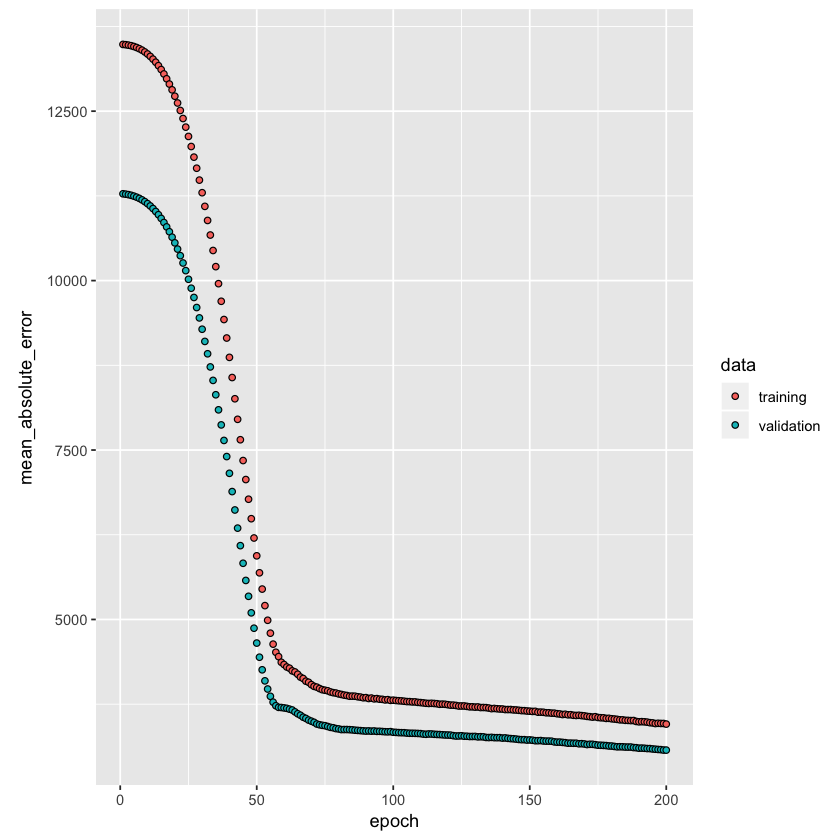

In [131]:
plot(history, metrics = "mean_absolute_error", smooth = FALSE)

In the graph shows the the MSE of the validation set is lower than the training set. This occurance is possible, but unlikely. I have also changed the seed to different numbers and have ended with some graphs that show training MSE's lower than the validation MSE. So this graph with a seed of 1 is one of those unlikely occurances that the validation MSE is lower than the training MSE due to the selections of the training and validation sets.

From the graph is looks like the training MSE shapely decreases from 0 to around 60 epochs. Then the training MSE still decreases but as a much slower rate.

In [132]:
model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu",
              input_shape = dim(train_data)[2]) %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mse",
  optimizer = optimizer_rmsprop(),
  metrics = list("mean_absolute_error")
)

In [133]:
early_stop <- callback_early_stopping(monitor = "val_loss", patience = 20)

In [134]:
#Fitting the model again but with an early stopping option.
history2 <- model %>% fit(
  train_data,
  train_labels,
  epochs = epochs,
  validation_split = 0.2,
  callbacks = list(early_stop)
)

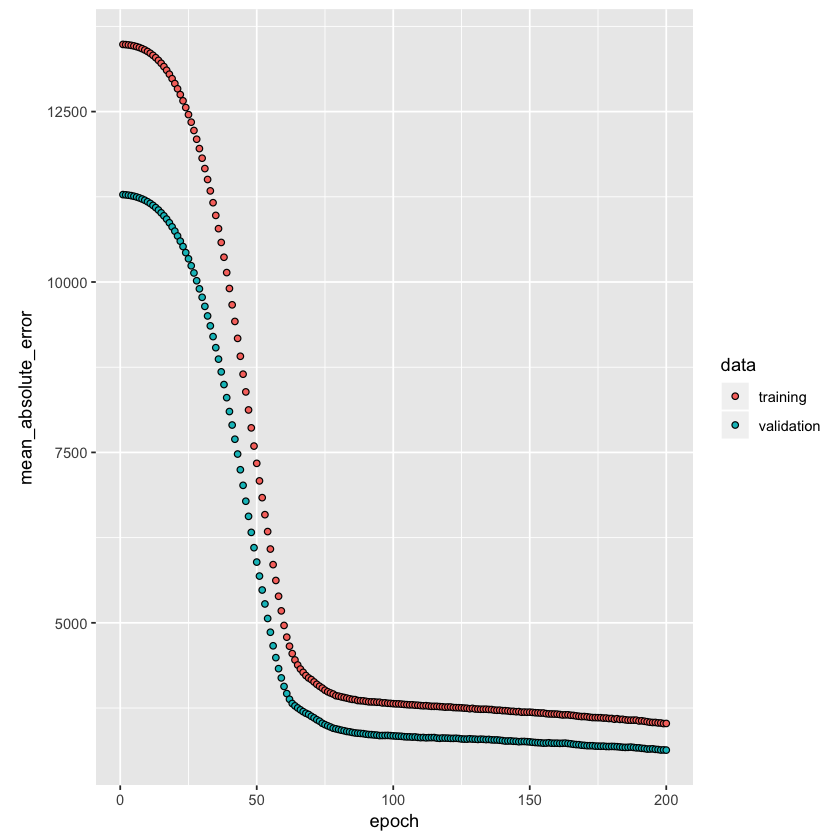

In [135]:
plot(history2, metrics = "mean_absolute_error", smooth = FALSE)

This graph also shows the validation MSE is lower than the training MSE which is possible but unlikely.

In [136]:
test_predictions <- model %>% predict(test_data)
mean((test_labels - test_predictions)^2)

[1] 36827815

The test MSE for Neural Networks is 36827814.511114.

# Comparing All Models

I used the same seed for the training and testing subset for all the models in order to calculate the test MSE for all the models.

The test MSE for Neural Networks is 36827814.511114. The test MSE for XGBoost is 70148809.07. The test MSE obtained from Boosting is 24883811.3586755. The test set MSE assoiated with the Random Forest is 25668956.15. The test set MSE for the Bagged regression tree is 26645123.9. The test MSE for OLS is 36725751.333074. While the test MSE for Ridge is 44739830.9942584 and the test MSE for Lasso is 41419898.3852836.

Out of all these methods, Boosting seems to be the best method because it has the lowest test MSE of 24883811.3586755.

# Conclusion

Using the Medical Cost Personal Dataset, I was able to analyze the data through various different methods. For the methods, I used the same testing and training subsets in order to be able to compare the models. Many of the methods worked better than the others such as Bagging, Random Forest, and Boosting. Out of all the methods, I believe that Boosting is the best method for the dataset as it had the lowest MSE and it's predicted vs actual graph predicted the actual values much better than the other method's predicted vs actual graphs. Overall, I've learned a lot from working on this project and will continue to use this experience in further projects to come!